# EPINR - Susceptibility Distortion Correction for Diffusion MRIs with Implicit Neural Representations

Tyler Spears, Tom Fletcher

In [1]:
def get_nb_path():
    # Adds the notebook's directory to sys.path for imports.
    import os
    from pathlib import Path
    from IPython import get_ipython

    nb_path = None
    # Try VSCode variable first.
    ipy_session = get_ipython()
    if ipy_session is not None:
        nb_path = ipy_session.user_ns.get("__vsc_ipynb_file__", None)
        if nb_path is None:
            nb_path = globals().get("__session__", None)
    if nb_path is None:
        # Try Jupyter environment variable next.
        nb_path = os.environ.get("JPY_SESSION_NAME", None)
    if nb_path is None:
        # Fallback: use current working directory.
        nb_path = Path(os.getcwd()).resolve()

    return Path(nb_path).resolve()

In [ ]:
# Imports
# %autoreload 2
# %matplotlib ipympl
import os

os.environ["CUDA_VISIBLE_DEVICES"] = os.environ.get("CUDA_VISIBLE_DEVICES", "0")
# By default, allow memory allocation to expand to avoid OOM errors
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = os.environ.get(
    "PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True"
)
# Force torch.load to use 'weights_only=False' by default, unless specified.
# <https://pytorch.org/docs/main/notes/serialization.html#environment-variables>
os.environ["TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD"] = os.environ.get(
    "TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD", "1"
)
# <https://github.com/pytorch/pytorch/issues/121197> and
# <https://github.com/NVIDIA/NeMo-Curator/pull/34>
os.environ["TORCHINDUCTOR_COMPILE_THREADS"] = os.environ.get(
    "TORCHINDUCTOR_COMPILE_THREADS", "2"
)
ENABLE_CUDNN_BENCHMARK = bool(int(os.environ.get("ENABLE_CUDNN_BENCHMARK", "1")))

import math
import random
import time
import sys
import shutil

# from dataclasses import dataclass
import collections
import dataclasses
import tempfile
import copy
from functools import partial
from pathlib import Path
from typing import Any, Optional, Literal, Callable

import torch.multiprocessing as multiprocessing  # noqa

import einops
import numpy as np
import pandas as pd
from box import Box
import yaml

# visualization libraries
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import monai
import monai.data
import monai.transforms
import monai.losses

# Computation & ML libraries.
import nibabel as nib
import torch
import torch.func

# The flag below controls whether to allow TF32 on matmul. Defaults to False
# in PyTorch 1.12 and later. See
# <https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices>
# for details.
##
# Set this to True to force full precision matmuls, as registration can be sensitive to
# precision. Pytorch may complain, but the performance hit is (probably) worth the
# gain in precision.
torch.backends.cuda.matmul.allow_tf32 = False
torch.set_float32_matmul_precision("highest")
# The flag below controls whether to allow TF32 on cuDNN. Defaults to True.
torch.backends.cudnn.allow_tf32 = False
##
# torch.backends.cuda.matmul.allow_tf32 = True
# torch.set_float32_matmul_precision("medium")
# # The flag below controls whether to allow TF32 on cuDNN. Defaults to True.
# torch.backends.cudnn.allow_tf32 = True
# ##
# # Activate cudnn benchmarking to optimize convolution algorithm speed.
# if torch.backends.cudnn.enabled and ENABLE_CUDNN_BENCHMARK:
#     torch.backends.cudnn.benchmark = True

import mrinr


# Add the notebook's directory to sys.path for imports.
nb_path = get_nb_path()
if str(nb_path) not in sys.path:
    sys.path.insert(0, str(nb_path))
from data_utils import (
    PE_DIR_ALIASES,
    DWISubjectData,
    scale_vol,
    blur_mask,
    load_dwi_subject_data,
    central_diff_det_j,
)
from loss_utils import (
    WeightedNMIParzenLoss,
    NCC,
    DoGLaplacian,
)

## Function & Model Definitions

In [3]:
class Siren(torch.nn.Module):
    """SIREN implicit neural representation.

    From:
    V. Sitzmann, J. N. P. Martel, A. W. Bergman, D. B. Lindell, and G. Wetzstein,
        “Implicit Neural Representations with Periodic Activation Functions.”
        arXiv, Jun. 17, 2020. doi: 10.48550/arXiv.2006.09661.

    Implementation adapated from <https://github.com/lucidrains/siren-pytorch>
    """

    def __init__(
        self,
        in_features,
        hidden_features,
        out_features,
        num_layers,
        omega=1.0,
        omega_0=30.0,
        c: float = 6.0,
        bias=True,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_features = hidden_features
        self.in_features = in_features
        self.out_features = out_features
        self.c = c

        layers = list()
        for idx in range(num_layers):
            is_first = idx == 0
            omega_i = omega_0 if is_first else omega
            in_features_i = self.in_features if is_first else self.hidden_features

            layer = SirenBlock(
                omega=omega_i,
                is_first_layer=is_first,
                c=self.c,
                use_activation=True,
                in_features=in_features_i,
                out_features=self.hidden_features,
                bias=bias,
            )

            layers.append(layer)

        # Final layer without activation or bias. As a displacement field, there should
        # be no global translation component, so the bias is disabled.
        final_layer = SirenBlock(
            omega=omega,
            c=self.c,
            is_first_layer=False,
            use_activation=False,
            in_features=self.hidden_features,
            out_features=self.out_features,
            bias=False,
        )
        layers.append(final_layer)

        self.linear_layers = torch.nn.Sequential(*layers)

    def forward(self, x, return_intermediates: bool = False):
        if not return_intermediates:
            y = self.linear_layers(x)
        else:
            y_i = x
            intermediates = list()
            for lin in self.linear_layers:
                y_i = lin(y_i)
                intermediates.append(y_i)
            y = intermediates[-1], tuple(intermediates[:-1])
        return y


class SirenBlock(torch.nn.Module):
    def __init__(
        self,
        omega: float,
        is_first_layer: bool,
        c: float = 6,
        use_activation: bool = True,
        activate_fn_kwargs: dict = dict(),
        **linear_kwargs,
    ):
        """SIREN implicit neural representation linear and activation block.

        From:
        V. Sitzmann, J. N. P. Martel, A. W. Bergman, D. B. Lindell, and G. Wetzstein,
            “Implicit Neural Representations with Periodic Activation Functions.”
            arXiv, Jun. 17, 2020. doi: 10.48550/arXiv.2006.09661.

        Implementation adapated from <https://github.com/lucidrains/siren-pytorch>
        and <https://github.com/vsitzmann/siren/blob/master/explore_siren.ipynb>.

        Parameters
        ----------
        omega : float
            Sine scale parameter; determines sine weight and linear weight init.

            In the original paper, omega = 30 was chosen for many tests.
        is_first_layer : bool
            Indicator for being the first layer in the INR MLP.
        c : float, optional
            Constant to drive initial weight distribution, by default 6.

            This should probably not be changed, but it probably shouldn't be hardcoded.
        """

        super().__init__()

        self.linear = torch.nn.Linear(**linear_kwargs)
        if use_activation:
            self.activate_fn = mrinr.nn.Sine(omega, **activate_fn_kwargs)
        else:
            self.activate_fn = None

        self._init_siren_linear_(
            self.linear, omega=omega, is_first_layer=is_first_layer, c=c
        )

    def forward(self, x):
        y = self.linear(x)
        if self.activate_fn is not None:
            y = self.activate_fn(y)
        return y

    @staticmethod
    def _init_siren_linear_(
        l: torch.nn.Linear,
        omega: float,
        is_first_layer: bool,
        c: float,
    ):
        n = l.in_features
        if is_first_layer:
            omega_bound = 1 / n
        else:
            omega_bound = math.sqrt(c / n) / omega
        torch.nn.init.uniform_(l.weight, -omega_bound, omega_bound)
        if l.bias is not None:
            torch.nn.init.uniform_(l.bias, -omega_bound, omega_bound)

In [ ]:
# EPINR SIREN model with optional positional encoding and rigid affine layer.


class EPINR(torch.nn.Module):
    def __init__(
        self,
        hidden_features: int,
        num_layers: int,
        pe_dir: str,
        omega=1.0,
        omega_0=30.0,
        c: float = 6.0,
        non_rigid_affine: bool = False,
        non_rigid_affine_nonzero_thresh: Optional[float] = None,
        refine_fixed_rigid_affine: bool = False,
        bias=True,
        pos_enc: Optional[Literal["positional"] | Literal["gaussian"]] = None,
        sigma: Optional[float] = None,
        m_num_freqs: Optional[int] = None,
    ):
        self._init_kwargs = mrinr.nn.get_module_init_kwargs(
            locals(), extra_kwargs_dict=dict()
        )
        super().__init__()
        self.spatial_dims = 3
        self.in_features = self.spatial_dims
        self.pe_dir = pe_dir
        if self.pe_dir not in {"ap", "pa"}:
            raise NotImplementedError(f"Unsupported pe_dir: {self.pe_dir}")

        if non_rigid_affine:
            self.nonrigid_affine_layer = self._NonRigidAffineLayer(
                pe_dir=self.pe_dir,
                param_softshrink_lambda=non_rigid_affine_nonzero_thresh,
            )
        else:
            self.nonrigid_affine_layer = None

        self.out_features = 1
        self.pos_enc_sigma = sigma
        self.m_num_freqs = m_num_freqs
        if pos_enc == "positional":
            self.pos_enc = mrinr.nn.PositionalCoordEncoding(
                spatial_dims=self.spatial_dims,
                sigma_scale=self.pos_enc_sigma,
                m_num_freqs=self.m_num_freqs,
            )
            siren_in_features = self.pos_enc.out_features
        elif pos_enc == "gaussian":
            self.pos_enc = mrinr.nn.GaussianCoordEncodingPreSampled(
                spatial_dims=self.spatial_dims,
                sigma=self.pos_enc_sigma,
                m_num_freqs=self.m_num_freqs,
            )
            siren_in_features = self.pos_enc.out_features
        else:
            self.pos_enc = None
            siren_in_features = self.spatial_dims

        self.siren = Siren(
            in_features=siren_in_features,
            hidden_features=hidden_features,
            out_features=self.out_features,
            num_layers=num_layers,
            omega=omega,
            omega_0=omega_0,
            c=c,
            bias=bias,
        )
        #!TESTING
        # Initialize the final layer weights to be very small to start as a small
        # displacement field.
        with torch.no_grad():
            final_layer_init_range = 0.0001  # 0.000001
            torch.nn.init.uniform_(
                self.siren.linear_layers[-1].linear.weight,
                -final_layer_init_range,
                final_layer_init_range,
            )
        #!
        if refine_fixed_rigid_affine:
            self.fixed_rigid_affine = self._RigidAffineLayer()
        else:
            self.fixed_rigid_affine = None

    class _RigidAffineLayer(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.spatial_dims = 3
            self.theta = torch.nn.Parameter(torch.zeros(self.spatial_dims))
            self.translations = torch.nn.Parameter(torch.zeros(self.spatial_dims))

        def get_affine(self, homogeneous: bool = False):
            R_x = torch.eye(self.spatial_dims).to(self.theta)
            # [1, 0, 0],
            # [0, torch.cos(self.theta[0]), -torch.sin(self.theta[0])],
            # [0, torch.sin(self.theta[0]), torch.cos(self.theta[0])],
            R_x[1, 1] *= torch.cos(self.theta[0])
            R_x[1, 2] += -torch.sin(self.theta[0])
            R_x[2, 1] += torch.sin(self.theta[0])
            R_x[2, 2] *= torch.cos(self.theta[0])

            R_y = torch.eye(self.spatial_dims).to(self.theta)
            # [torch.cos(self.theta[1]), 0, torch.sin(self.theta[1])],
            # [0, 1, 0],
            # [-torch.sin(self.theta[1]), 0, torch.cos(self.theta[1])]
            R_y[0, 0] *= torch.cos(self.theta[1])
            R_y[0, 2] += torch.sin(self.theta[1])
            R_y[2, 0] += -torch.sin(self.theta[1])
            R_y[2, 2] *= torch.cos(self.theta[1])

            R_z = torch.eye(self.spatial_dims).to(self.theta)
            # [torch.cos(self.theta[2]), -torch.sin(self.theta[2]), 0],
            # [torch.sin(self.theta[2]), torch.cos(self.theta[2]), 0],
            # [0, 0, 1],
            R_z[0, 0] *= torch.cos(self.theta[2])
            R_z[0, 1] += -torch.sin(self.theta[2])
            R_z[1, 0] += torch.sin(self.theta[2])
            R_z[1, 1] *= torch.cos(self.theta[2])

            R = R_x @ R_y @ R_z
            if homogeneous:
                A = torch.eye(
                    self.spatial_dims + 1,
                    device=self.translations.device,
                    dtype=self.translations.dtype,
                )
                A[: self.spatial_dims, : self.spatial_dims] = R
                A[:-1, -1] = self.translations
                r = A
            else:
                r = R, self.translations
            return r

        def forward(self, x):
            R, t = self.get_affine(homogeneous=False)
            y = einops.einsum(x, R, "... i, i j -> ... j") + t
            # linear() requires a transposed matrix.
            # y = torch.nn.functional.linear(x, weight=R.T, bias=self.translations)
            return y

    class _NonRigidAffineLayer(torch.nn.Module):
        def __init__(
            self,
            pe_dir: str,
            param_softshrink_lambda: Optional[float] = None,
        ):
            super().__init__()
            self.spatial_dims = 3
            self.pe_dir = pe_dir
            if self.pe_dir not in {"ap", "pa"}:
                raise NotImplementedError(f"Unsupported pe_dir: {self.pe_dir}")
            self.scales = torch.nn.Parameter(torch.ones(self.spatial_dims))
            self.shears = torch.nn.Parameter(torch.zeros(self.spatial_dims))
            if (param_softshrink_lambda is None) or (param_softshrink_lambda == 0.0):
                self.param_nonlinear = None
            else:
                self.param_nonlinear = torch.nn.Softshrink(
                    lambd=param_softshrink_lambda
                )

        def get_affine(self, homogeneous: bool = False):
            # Apply nonlinear to parameters so they remain at identity when only small
            # updates are made, ensuring that large gradients are needed to "activate"
            # the affine transformation.
            if self.param_nonlinear is not None:
                scales = self.param_nonlinear(self.scales - 1.0) + 1.0
                shears = self.param_nonlinear(self.shears)
            else:
                scales = self.scales
                shears = self.shears
            # Scaling matrix.
            S = torch.diag(scales)
            # Shear matrix.
            P = torch.eye(self.spatial_dims, dtype=shears.dtype, device=shears.device)
            P[0, 1] = shears[0]  # shear xy
            # shear xz, which is 0 for AP/PA PE directions.
            P[0, 2] = shears[1] * 0.0
            P[1, 2] = shears[2]  # shear yz

            A = S @ P
            if homogeneous:
                A = torch.nn.functional.pad(A, pad=(0, 1, 0, 1), value=0.0)
                A[-1, -1] = 1.0
            return A

    def get_extra_state(self) -> Any:
        return {"init_kwargs": self._init_kwargs}

    def set_extra_state(self, state):
        return

    def fixed2moving_rigid_affine_parameters(self):
        if self.fixed_rigid_affine is not None:
            return self.fixed_rigid_affine.parameters()
        else:
            return list()

    def moving2fixed_nonrigid_affine_parameters(self):
        if self.nonrigid_affine_layer is not None:
            return self.nonrigid_affine_layer.parameters()
        else:
            return list()

    def network_parameters(self):
        p_iter_all = self.parameters()
        fix2mov_rigid_params = list(self.fixed2moving_rigid_affine_parameters())
        mov2fix_nonrigid_params = list(self.moving2fixed_nonrigid_affine_parameters())
        affine_params = set(fix2mov_rigid_params + mov2fix_nonrigid_params)
        net_params = [p for p in p_iter_all if p not in affine_params]
        return net_params

    @property
    def fixed2moving_rigid_affine(
        self,
    ) -> mrinr.typing.SingleHomogeneousAffine3D | None:
        if self.fixed_rigid_affine is not None:
            A = self.fixed_rigid_affine.get_affine(homogeneous=True)
        else:
            A = None
        return A

    def apply_fixed_rigid_affine(
        self, x: mrinr.typing.CoordGrid3D
    ) -> mrinr.typing.CoordGrid3D:
        if self.fixed_rigid_affine is not None:
            y = self.fixed_rigid_affine(x)
        else:
            y = x
        return y

    def _get_reshape_fns(
        self,
        x: mrinr.typing.CoordGrid3D | torch.Tensor,
        grid_fov: torch.Tensor,
        grid_min_coord: torch.Tensor,
    ) -> tuple[Callable, Callable]:
        """Get functions to reshape coordinates to/from grids.

        Helps with handling inputs that are either full coordinate grids or just
        batches of coordinates, the latter of which is useful for Jacobian/Hessian computations."""
        assert (
            x.ndim == grid_fov.ndim == grid_min_coord.ndim
        ), f"Input shapes mismatch: {x.shape =}, {grid_fov.shape =}, {grid_min_coord.shape =}"
        x_orig_shape = tuple(x.shape)
        if x.ndim <= 2 and x.shape[-1] == self.spatial_dims:
            if x.ndim == 1:
                coords_to_grid_reshape = lambda a: einops.repeat(
                    a,
                    "coord -> b x y z coord",
                    b=1,
                    x=1,
                    y=1,
                    z=1,
                    coord=self.spatial_dims,
                )
                grid_to_coords_reshape = lambda a: einops.rearrange(
                    a,
                    "b x y z coord -> (b x y z) coord",
                    b=1,
                    x=1,
                    y=1,
                    z=1,
                    coord=self.spatial_dims,
                ).squeeze(0)
            else:
                coords_to_grid_reshape = lambda a: einops.rearrange(
                    a,
                    "(b x y z) coord -> b x y z coord",
                    x=1,
                    y=1,
                    z=1,
                    coord=self.spatial_dims,
                )
                grid_to_coords_reshape = lambda a: einops.rearrange(
                    a,
                    "b x y z coord -> (b x y z) coord",
                    b=x_orig_shape[0],
                    coord=self.spatial_dims,
                )
        else:
            # Identity functions.
            coords_to_grid_reshape = lambda a: a
            grid_to_coords_reshape = lambda a: a
        return coords_to_grid_reshape, grid_to_coords_reshape

    def forward(
        self,
        x: mrinr.typing.CoordGrid3D | torch.Tensor,
        grid_fov: torch.Tensor,
        grid_min_coord: torch.Tensor,
        _scale_by_fov: bool = True,
        _add_nonrigid: bool = True,
    ) -> mrinr.typing.CoordGrid3D:
        # print(f"{x.shape =}, {grid_fov.shape =}, {grid_min_coord.shape =}")
        # Inputs should be 3D coordinate grids, but if they are just a batch of 3D
        # coordinates, then reshape to a grid.
        coords_to_grid_reshape, grid_to_coords_reshape = self._get_reshape_fns(
            x, grid_fov, grid_min_coord
        )
        x = coords_to_grid_reshape(x)
        grid_fov = coords_to_grid_reshape(grid_fov)
        grid_min_coord = coords_to_grid_reshape(grid_min_coord)

        # Use a learned non-rigid affine transformation to create a secondary displacement
        # field.
        if self.nonrigid_affine_layer is not None:
            # Broadcast batch dim.
            A = self.nonrigid_affine_layer.get_affine(homogeneous=True).unsqueeze(0)
            Ax = mrinr.coords.transform_coords(x, affine_a2b=A, broadcast_batch=True)
            y_nonrigid = Ax - x
        else:
            y_nonrigid = None

        # Scale the input coordinates to the range [-1, 1] based on the entire volume's
        # field of view and lowest coordinate.
        norm_x = (((x - grid_min_coord) / grid_fov) * 2.0) - 1.0

        # Positional encoding of input coordinates.
        if self.pos_enc is not None:
            x_enc = self.pos_enc(norm_x)
        else:
            x_enc = mrinr.nn.coords_as_channels(norm_x, has_batch_dim=True)
        x_enc = einops.rearrange(x_enc, "b c x y z -> (b x y z) c")
        y = self.siren(x_enc)
        # Reshape back into a coordinate grid, and return.
        y = einops.rearrange(
            y,
            "(b x y z) coord -> b x y z coord",
            x=x.shape[1],
            y=x.shape[2],
            z=x.shape[3],
        )

        y = torch.cat([torch.zeros_like(y), y, torch.zeros_like(y)], dim=-1)
        # Unscale the output coordinates to the grid.
        # y = (y * grid_fov) + grid_min_coord
        if _scale_by_fov:
            y = y * grid_fov
        if y_nonrigid is not None and _add_nonrigid:
            y = y + y_nonrigid
        y = grid_to_coords_reshape(y)
        return y

In [ ]:
# Regularization functions using pytorch's functional jacobian and hessian.
def jacobian_matrix_batched(
    pred_displacement_net: torch.nn.Module,
    x_coords: mrinr.typing.ScalarVolume,
    grid_fov: torch.Tensor,
    grid_min_coord: torch.Tensor,
    jac_of_warp_type: str = "deformation",
    compile_jacobian: bool = False,
):
    jac_of_warp_type = jac_of_warp_type.lower().strip()
    deformation_grad = "deform" in jac_of_warp_type
    displacement_grad = "displac" in jac_of_warp_type
    assert (
        deformation_grad ^ displacement_grad
    ), "Either deformation_grad or displacement_grad must be True."
    is_training = pred_displacement_net.training
    # Set network to eval mode to disable batchnorms, but keep gradients enabled.
    pred_displacement_net.eval()

    # Reshape everything to be of shape B x 3, to make the vmap easier.
    orig_x_shape = tuple(x_coords.shape)
    x_coords = einops.rearrange(
        x_coords,
        "b x y z coord -> (b x y z) coord",
        coord=3,
    )
    grid_fov = einops.rearrange(
        grid_fov,
        "b x y z coord -> (b x y z) coord",
        coord=3,
    )
    grid_min_coord = einops.rearrange(
        grid_min_coord,
        "b x y z coord -> (b x y z) coord",
        coord=3,
    )
    # Create function for the Jacobian of the *deformation* field using
    # reverse-mode auto-diff.
    if deformation_grad:
        jac_fn = torch.func.jacrev(
            lambda x, f, m: pred_displacement_net(x, f, m) + x, argnums=0
        )
    else:
        jac_fn = torch.func.jacrev(
            lambda x, f, m: pred_displacement_net(x, f, m), argnums=0
        )
    # Vectorize the Jacobian function over the batch size.
    # Ensure all Tensors have the same batch size.
    grid_fov = grid_fov.expand_as(x_coords)
    grid_min_coord = grid_min_coord.expand_as(x_coords)
    v_jac_fn = torch.vmap(jac_fn, in_dims=(0, 0, 0), out_dims=0, randomness="error")
    if compile_jacobian:
        v_jac_fn = torch.compile(v_jac_fn)

    # Compute the Jacobian.
    J = v_jac_fn(x_coords, grid_fov, grid_min_coord)
    # Reshape the batch dims to match the input shape.
    J = einops.rearrange(
        J,
        "(b x y z) n_coord m_coord -> b x y z n_coord m_coord",
        b=orig_x_shape[0],
        x=orig_x_shape[1],
        y=orig_x_shape[2],
        z=orig_x_shape[3],
    )

    pred_displacement_net.train(is_training)
    return J


def bending_energy_regularization(
    pred_displacement_net: torch.nn.Module,
    x_coords: mrinr.typing.ScalarVolume,
    grid_fov: torch.Tensor,
    grid_min_coord: torch.Tensor,
    pe_dir: str,
    hessian_of_warp_type: str = "deformation",
    compile_hessian: bool = False,
) -> torch.Tensor:
    hess_of_warp_type = hessian_of_warp_type.lower().strip()
    deformation_grad = "deform" in hess_of_warp_type
    displacement_grad = "displac" in hess_of_warp_type
    assert (
        deformation_grad ^ displacement_grad
    ), "Either deformation_grad or displacement_grad must be True."
    is_training = pred_displacement_net.training
    # Set network to eval mode to disable batchnorms, but keep gradients enabled.
    pred_displacement_net.eval()

    # Reshape everything to be of shape B x 3, to make the vmap easier.
    orig_x_shape = tuple(x_coords.shape)
    x_coords = einops.rearrange(
        x_coords,
        "b x y z coord -> (b x y z) coord",
        coord=3,
    )
    orig_grid_fov = grid_fov
    grid_fov = einops.rearrange(
        orig_grid_fov,
        "b x y z coord -> (b x y z) coord",
        coord=3,
    )
    grid_min_coord = einops.rearrange(
        grid_min_coord,
        "b x y z coord -> (b x y z) coord",
        coord=3,
    )
    # Create function for the Hessian of the *deformation* field using
    # reverse-mode auto-diff.
    if deformation_grad:
        hessian_fn = torch.func.hessian(
            lambda x, f, m: pred_displacement_net(x, f, m) + x, argnums=0
        )
    else:
        hessian_fn = torch.func.hessian(
            lambda x, f, m: pred_displacement_net(x, f, m), argnums=0
        )

    pe_dir = PE_DIR_ALIASES[pe_dir]
    # The Hessian should only be non-zero along the PE direction.
    if pe_dir in {"ap", "pa"}:
        hessian_fn_pe = lambda x, f, m: hessian_fn(x, f, m)[
            ..., 1
        ]  # Y coordinate of the output vector.
    else:
        raise ValueError(f"Unsupported PE direction: {pe_dir}")

    # Vectorize the Hessian function over the batch size.
    # Ensure all Tensors have the same batch size.
    grid_fov = grid_fov.expand_as(x_coords)
    grid_min_coord = grid_min_coord.expand_as(x_coords)
    v_hessian_fn_pe = torch.vmap(
        hessian_fn_pe, in_dims=(0, 0, 0), out_dims=0, randomness="error"
    )
    if compile_hessian:
        v_hessian_fn_pe = torch.compile(v_hessian_fn_pe)
    # Compute the full 3D, batched Hessian.
    H_pe = v_hessian_fn_pe(x_coords, grid_fov, grid_min_coord)
    # Reshape the dims to match the input shape.
    # Shape of Hessian tensor without batch dims:
    # out_dims_m x in_dims_n x in_dims_n
    # which is just a batch of Hessian matrices such that for every output dimension k,
    # there is a Hessian matrix H_k of all input dimension combinations:
    # H_k_ij = d^2 f_k / (d x_i d x_j)
    H_pe = einops.rearrange(
        H_pe,
        "(b x y z) n_coord_1 n_coord_2 -> b x y z n_coord_1 n_coord_2",
        b=orig_x_shape[0],
        x=orig_x_shape[1],
        y=orig_x_shape[2],
        z=orig_x_shape[3],
    )

    # Normalizing domain volume/size.
    # V = orig_grid_fov.reshape(orig_x_shape[0], 3).prod(dim=-1)
    # # Compute bending energy.
    # # Sum over all spatial locations and coordinate directions, normalizing by batch-wise
    # # FOV/volume.
    # l_bending = (
    #     einops.reduce(
    #         H_pe**2,
    #         "b x y z n_coord_1 n_coord_2 -> b",
    #         "sum",
    #         b=orig_x_shape[0],
    #         x=orig_x_shape[1],
    #         y=orig_x_shape[2],
    #         z=orig_x_shape[3],
    #         n_coord_1=3,
    #         n_coord_2=3,
    #     )
    #     / V
    # )
    #
    # Compute bending energy.
    # Sum over all spatial locations and coordinate directions, normalizing by batch-wise
    # FOV/volume.
    l_bending = einops.reduce(
        H_pe**2,
        "b x y z n_coord_1 n_coord_2 -> b x y z",
        "sum",
        b=orig_x_shape[0],
        x=orig_x_shape[1],
        y=orig_x_shape[2],
        z=orig_x_shape[3],
        n_coord_1=3,
        n_coord_2=3,
    ).mean()
    #

    pred_displacement_net.train(is_training)
    return l_bending


def jac_displace_fro_regularization(J_displace: torch.Tensor) -> torch.Tensor:
    spatial_dims = 3
    # Compute the Jacobian determinant for regularization.
    # Last 2 dimensions of J should be the coordinate dimensions.
    J = J_displace
    assert J.shape[-1] == J.shape[-2] == spatial_dims
    J = J.view(-1, spatial_dims, spatial_dims)
    l = torch.linalg.matrix_norm(J, ord="fro", dim=(-2, -1)) ** 2
    l = l.mean()
    return l

## Data Processing & Loading

In [6]:
# Final preprocessing of volumes after loading, but before training.
def prep_vols(
    b0,
    b0_mask,
    b0_affine,
    t1w,
    t1w_mask,
    t1w_affine,
    scale_kwargs: dict,
    blur_mask_kwargs: dict,
) -> dict:
    # Scale the volumes to have similar intensity ranges.
    b0 = scale_vol(b0, **scale_kwargs)
    t1w = scale_vol(t1w, **scale_kwargs)
    # Blur masks to focus training loss on brain tissue instead of skull/background.
    b0_spacing = mrinr.coords.spacing(b0_affine)
    b0_mask = blur_mask(b0_mask, spacing=b0_spacing, **blur_mask_kwargs)
    t1w_spacing = mrinr.coords.spacing(t1w_affine)
    t1w_mask = blur_mask(t1w_mask, spacing=t1w_spacing, **blur_mask_kwargs)
    vols = dict(
        b0=b0,
        b0_mask=b0_mask,
        t1w=t1w,
        t1w_mask=t1w_mask,
    )
    return vols

## Susceptibility Distortion Field Reconstruction

### Parameters

In [ ]:
# Papermill parameters, used by the CLI wrapper script.
# -------------------------------------------------------------------------------------
# *NOTE* This cell is parsed by papermill, and only variable assignments should be
# present here. Otherwise, operations may not be applied to the desired variables.
# See <https://papermill.readthedocs.io/en/latest/usage-parameterize.html>
# for more details.
# General parameters, also used in notebook mode.
continue_previous_run: bool = False
device = "cuda:0" if torch.cuda.is_available() else "cpu"
compile_hessian: bool = True
save_debug_outputs: bool = True
in_pml: bool = False
pml_params: dict[str, Any] = dict()
pml_merge_with_default_params: bool = True
pml_subj_run_mode: Literal["single"] | Literal["batch"] = "batch"
pml_dataset_table_f: Optional[Path] = None
## Single subject run parameters.
# Output paths for a single subject.
pml_single_subj_out_fmap: Optional[Path] = None
pml_single_subj_out_corrected_b0: Optional[Path] = None
pml_single_subj_out_weights: Optional[Path] = None
# Directory to save debug/validation results, if requested.
pml_single_subj_out_debug_dir: Optional[Path] = None
## Batch subject run parameters.
# Output directory for batch subject runs.
pml_batch_out_dir: Optional[Path] = None
pml_batch_dataset_dirs: Optional[dict[str, Path]] = dict()
pml_batch_prepend_timestamp: bool = True
# -------------------------------------------------------------------------------------
# Papermill will inject a new cell immediately after this one with updated parameter
# variable assignments.

In [ ]:
# Parse & validate papermill parameters if running in papermill.
device = torch.device(device)
if in_pml:
    if pml_dataset_table_f is None:
        raise ValueError("dataset_table_f must be provided in papermill mode.")

    if pml_subj_run_mode == "batch":
        if pml_batch_out_dir is None:
            raise ValueError("pml_batch_out_dir must be provided for batch runs.")
        if len(pml_batch_dataset_dirs) == 0:
            raise ValueError("pml_batch_dataset_dirs must be provided for batch runs.")
    elif pml_subj_run_mode == "single":
        if (
            (pml_single_subj_out_fmap is None)
            and (pml_single_subj_out_corrected_b0 is None)
            and (pml_single_subj_out_weights is None)
            and (pml_single_subj_out_debug_dir is None)
        ):
            raise ValueError(
                "At least one output path must be provided for single subject runs."
            )
        if save_debug_outputs and (pml_single_subj_out_debug_dir is None):
            raise ValueError(
                "pml_single_subj_out_debug_dir must be provided if save_debug_outputs is True."
            )
    else:
        raise ValueError(f"Unsupported pml_subj_run_mode: {pml_subj_run_mode}")

    # Collect papermill config.
    pml_config = dict()
    pml_config["params"] = pml_params
    # These parameters will be cleared of defaults whenever papermill is being used, and
    # must be specified from the CLI wrapper script.
    pml_config["params_to_clear"] = (
        "experiment_label",
        "result_base_dir",
        "dataset_table_f",
        "dataset_dirs",
    )
    pml_config["merge_with_default_params"] = pml_merge_with_default_params
    pml_config["subj_run_mode"] = pml_subj_run_mode
    # pml_config["override_params"] = dict()
    pml_config["params"]["dataset_table_f"] = (
        Path(pml_dataset_table_f).expanduser().resolve()
    )
    if pml_subj_run_mode == "batch":
        for k, v in pml_batch_dataset_dirs.items():
            pml_batch_dataset_dirs[k] = Path(v).expanduser().resolve()
        pml_config["params"]["dataset_dirs"] = pml_batch_dataset_dirs
        pml_batch_out_dir = Path(pml_batch_out_dir).expanduser().resolve()
        pml_config["params"]["result_base_dir"] = pml_batch_out_dir.parent
        pml_config["params"]["experiment_label"] = pml_batch_out_dir.name
        if pml_batch_prepend_timestamp:
            timestamp_str = mrinr.utils.timestamp_now()
            pml_config["params"]["experiment_label"] = (
                f"{timestamp_str}_{pml_config['params']['experiment_label']}"
            )

    elif pml_subj_run_mode == "single":
        pml_config["params"]["dataset_dirs"] = None
        timestamp_str = mrinr.utils.timestamp_now()
        tmp_result_dir_name = tempfile.mkdtemp(
            prefix=f"tmp-{timestamp_str}-",
            suffix="__epinr_dmri_single_subject",
        )
        pml_config["params"]["result_base_dir"] = Path(tmp_result_dir_name).resolve()
        pml_config["params"]["experiment_label"] = "epinr_single_subject_run"
        pml_config["out_fmap"] = (
            Path(pml_single_subj_out_fmap).expanduser().resolve()
            if pml_single_subj_out_fmap is not None
            else None
        )
        pml_config["out_corrected_b0"] = (
            (Path(pml_single_subj_out_corrected_b0).expanduser().resolve())
            if pml_single_subj_out_corrected_b0 is not None
            else None
        )
        pml_config["out_weights"] = (
            (Path(pml_single_subj_out_weights).expanduser().resolve())
            if pml_single_subj_out_weights is not None
            else None
        )
        pml_config["out_debug_dir"] = (
            (Path(pml_single_subj_out_debug_dir).expanduser().resolve())
            if pml_single_subj_out_debug_dir is not None
            else None
        )
else:
    pml_config = None

# Delete papermill parameters from the global namespace to avoid confusion. All
# parameters should be accessed with the pml_config dict.
del (
    pml_params,
    pml_merge_with_default_params,
    pml_subj_run_mode,
    pml_dataset_table_f,
    pml_single_subj_out_fmap,
    pml_single_subj_out_corrected_b0,
    pml_single_subj_out_weights,
    pml_single_subj_out_debug_dir,
    pml_batch_out_dir,
    pml_batch_dataset_dirs,
    pml_batch_prepend_timestamp,
)

In [ ]:
# Experiment params
# Default parameters, will be used unless overridden by papermill params.
params = Box(
    dict(
        # Experiment setup and file location parameters.
        experiment_label="epinr_dmri_test",
        result_base_dir=Path("~/mnt/magpie/outputs/results/epinr/dmri/epinr/")
        .expanduser()
        .resolve(),
        dataset_table_f=(
            nb_path.parent
            / Path("data_tables/ablation_merged_subset_dataset_table.csv")
            # (
            #     nb_path.parent / Path("data_tables/merged_dmri_dataset_table.csv")
            # )
        ),
        dataset_dirs={
            "mica_mics": Path(
                "~/mnt/magpie/outputs/mica_mics/derivatives/epinr_fmap_learning"
            )
            .expanduser()
            .resolve(),
            "vcu_ms": Path(
                "~/mnt/magpie/outputs/vcu_ms_epinr/derivatives/epinr_fmap_learning"
            )
            .expanduser()
            .resolve(),
        },
        # Training parameters.
        epochs=60,
        n_repeats_per_epoch=50,
        effective_batch_size=6,
        batch_size=3,
        patch_size=(32, 32, 32),
        # Preprocessing parameters
        winsorize_quantiles=(0.01, 0.99),
        feature_range=(0.0, 1.0),
        mask_blur_sigma_mm=2.0,
        mask_blur_truncate=5.0,
        # INR model params
        hidden_features=256,
        num_layers=4,
        omega=1.0,
        omega_0=30.0,
        c=6.0,
        # Learnable affine transform params.
        # Moving volume non-rigid affine components.
        non_rigid_affine_layer=False,
        non_rigid_affine_nonzero_thresh=None,
        # Fixed volume, refined with rigid affine only.
        refine_fixed_rigid_affine=False,
        # Percentage of training epochs that will optimize the fixed volume alignment.
        # After this percentage of epochs, the fixed volume rigid affine will be
        # frozen.
        refine_fixed_rigid_affine_epoch_percent=0.0,
        # Positional encoding params
        m_num_freqs=None,
        pos_enc_sigma=None,
        pos_enc_type=None,
        # Training function params
        optim_lr=0.0005,
        optim_weight_decay=0.01,
        optim_betas=(0.9, 0.999),
        # Linear LR scheduler end scale factor.
        lr_scheduler_end_factor=0.01,
        # Percentage of training epochs for constant warmup and constant cooldown
        # phases, both before and after the linear decay phase. Each warmup and cooldown
        # phase lasts for this percentage, so the linear decay phase lasts for
        # 1 - (2 * this percentage).
        lr_scheduler_warmup_cooldown_percent=0.1,
        # Whether to use Jacobian modulation during training, and whether to use the
        # analytic form from the network, or a finite difference approximation.
        enable_jac_mod_in_training=True,
        use_analytic_jac_mod=True,
        mse_sim_weight=0.0,
        mi_sim_weight=1.0,
        mi_sim_kwargs=dict(
            num_bins=32, sigma_ratio=0.5, norm_mi=False, norm_images=True
        ),
        ncc_sim_weight=0.0,
        lncc_sim_weight=0.0,
        lncc_sim_kwargs=dict(kernel_size=9, kernel_type="rectangular"),
        laplacian_ncc_sim_weight=0.5,
        laplacian_mse_sim_weight=0.0,
        laplacian_sigma_low=0.5,
        laplacian_truncate=2.0,
        jac_fro_reg_weight=1.5,
        bending_energy_reg_weight=2.0,
        resample_kwargs=dict(
            mode_or_interpolation="linear",
            padding_mode_or_bound="zeros",
            interp_lib="torch",
        ),
        val_mi_sim_kwargs=dict(kernel_type="gaussian", num_bins=32, sigma_ratio=0.5),
    ),
    viz_val_epoch_fraction=0.1,
)

if in_pml:
    # Override some parameters with papermill config.
    for k in pml_config["params_to_clear"]:
        params.pop(k)
    # Let user choose whether to merge other parameters with the defaults, or replace
    # all of them entirely.
    if pml_config["merge_with_default_params"]:
        params.merge_update(pml_config["params"])
    else:
        params = Box(pml_config["params"])

# Derive any additional parameters from the base parameters.
if params.result_base_dir is not None:
    params.result_base_dir.mkdir(parents=True, exist_ok=True)
# Calculate number of gradient accumulation steps.
_grad_accumulate_steps = params.effective_batch_size / params.batch_size
assert _grad_accumulate_steps.is_integer(), (
    f"Effective batch size {params.effective_batch_size} must be "
    f"a multiple of batch size {params.batch_size}."
)
params.grad_accumulate_steps = int(_grad_accumulate_steps)
del _grad_accumulate_steps
params.n_batches_per_epoch = params.n_repeats_per_epoch * params.grad_accumulate_steps
if save_debug_outputs:
    params.viz_validation_every_n_epochs = max(
        1, int(params.epochs * params.viz_val_epoch_fraction)
    )
else:
    params.viz_validation_every_n_epochs = 0

### Training Loop

In [10]:
def validation_step(
    epinr: EPINR,
    subj_data: DWISubjectData,
    params: Box,
    epoch: int,
    step: int,
    val_score_fns: dict,
    b0_spacing: torch.Tensor,
    viz_validation_every: int,
    pr=print,
) -> dict:
    # Convenience functions for resampling volumes.
    sample_scaled_t1w = lambda c: mrinr.grid_resample(
        subj_data.scaled_t1w.expand(c.shape[0], -1, -1, -1, -1),
        affine_x_el2coords=subj_data.t1w_affine,
        sample_coords=c,
        **params.resample_kwargs,
    )
    sample_b0 = lambda c: mrinr.grid_resample(
        subj_data.b0.expand(c.shape[0], -1, -1, -1, -1),
        affine_x_el2coords=subj_data.b0_affine,
        sample_coords=c,
        **params.resample_kwargs,
    )
    sample_scaled_b0 = lambda c: mrinr.grid_resample(
        subj_data.scaled_b0.expand(c.shape[0], -1, -1, -1, -1),
        affine_x_el2coords=subj_data.b0_affine,
        sample_coords=c,
        **params.resample_kwargs,
    )

    # Break up the prediction into smaller chunks to avoid OOM errors.
    n_chunks = 16
    b0_coord_grid_chunks = torch.chunk(
        subj_data.b0_scanner_coord_grid, n_chunks, dim=-2
    )
    pred_displacement_field_mm_chunks = list()
    J_chunks = list()
    J_deform_chunks = list()
    for b0_coord_grid_chunk in b0_coord_grid_chunks:
        pred_displacement_field_mm_chunk = epinr(
            x=b0_coord_grid_chunk,
            grid_fov=subj_data.b0_fov,
            grid_min_coord=subj_data.b0_min_coord,
        )
        pred_displacement_field_mm_chunks.append(pred_displacement_field_mm_chunk)
        J_chunk = jacobian_matrix_batched(
            pred_displacement_net=epinr,
            x_coords=b0_coord_grid_chunk,
            grid_fov=subj_data.b0_fov,
            grid_min_coord=subj_data.b0_min_coord,
            jac_of_warp_type="displacement",
        )
        J_chunks.append(J_chunk)
        J_deform_chunk = jacobian_matrix_batched(
            pred_displacement_net=epinr,
            x_coords=b0_coord_grid_chunk,
            grid_fov=subj_data.b0_fov,
            grid_min_coord=subj_data.b0_min_coord,
            jac_of_warp_type="deformation",
        )
        J_deform_chunks.append(J_deform_chunk)
    pred_displacement_field_mm = torch.cat(pred_displacement_field_mm_chunks, dim=-2)
    J = torch.cat(J_chunks, dim=-3)
    det_J_ap = 1 + J[:, None, ..., 1, 1]
    J_deform = torch.cat(J_deform_chunks, dim=-3)
    # Sample the moving b0 volume with the predicted displacement field.
    moving_b0_sample = det_J_ap * sample_b0(
        subj_data.b0_scanner_coord_grid + pred_displacement_field_mm
    )
    moving_scaled_b0_sample = det_J_ap * sample_scaled_b0(
        subj_data.b0_scanner_coord_grid + pred_displacement_field_mm
    )

    ## Compute validation scores.
    # Sample the fixed volume without any affine refinement.
    t1w_coord_grid = mrinr.coords.affine_coord_grid(
        subj_data.t1w_affine,
        subj_data.scaled_t1w.shape[-3:],
    ).to(subj_data.b0_scanner_coord_grid)
    # Sample T1w at the coordinates of the moving image for quant. comparison.
    fixed_t1w_sample = sample_scaled_t1w(subj_data.b0_scanner_coord_grid)
    # Also sample at the full T1w resolution for visualization.
    viz_fixed_t1w_sample = sample_scaled_t1w(t1w_coord_grid)
    # if epinr.fixed2moving_rigid_affine is not None:
    #     rigid_refine_fixed_t1w_sample = sample_scaled_t1w(
    #         epinr.apply_fixed_rigid_affine(t1w_coord_grid)
    #     )
    # else:
    #     rigid_refine_fixed_t1w_sample = None
    # Convert predicted displacement field from mm to hz for comparison with topup.
    pred_displacement_field_hz = (
        (pred_displacement_field_mm[..., 1] * (-1 if subj_data.pe_dir == "ap" else 1))
        / b0_spacing[0, 1].cpu().numpy().item()
    ) / subj_data.total_readout_time_s

    # Calculate validation scores for this epoch.
    val_scores_epoch_i = {
        "fixed_moving_mi": val_score_fns["fixed_moving_mi"](
            moving_scaled_b0_sample, fixed_t1w_sample
        )
        .cpu()
        .item(),
        "fixed_moving_ncc": val_score_fns["fixed_moving_ncc"](
            moving_scaled_b0_sample, fixed_t1w_sample
        )
        .cpu()
        .item(),
        "det_J_def_neg_frac": val_score_fns["det_J_def_neg_frac"](J_deform)
        .cpu()
        .item(),
    }
    # Validate against topup GTs if available.
    if subj_data.topup_displace_hz is not None:
        val_scores_epoch_i["topup_suscept_mse"] = (
            val_score_fns["topup_suscept_mse"](
                pred_displacement_field_hz.unsqueeze(0), subj_data.topup_displace_hz
            )
            .cpu()
            .item()
        )
        val_scores_epoch_i["masked_topup_suscept_mse"] = (
            val_score_fns["masked_topup_suscept_mse"](
                pred_displacement_field_hz.unsqueeze(0),
                subj_data.topup_displace_hz,
                subj_data.b0_mask,
            )
            .cpu()
            .item()
        )
    if subj_data.topup_corrected_b0 is not None:
        val_scores_epoch_i["topup_corrected_b0_mse"] = (
            val_score_fns["topup_corrected_b0_mse"](
                moving_b0_sample, subj_data.topup_corrected_b0
            )
            .cpu()
            .item()
        )
        val_scores_epoch_i["masked_topup_corrected_b0_mse"] = (
            val_score_fns["masked_topup_corrected_b0_mse"](
                moving_b0_sample,
                subj_data.topup_corrected_b0,
                subj_data.b0_mask,
            )
            .cpu()
            .item()
        )

    pr(f"Validation scores at epoch {epoch}:")
    for metric_name, val_score in val_scores_epoch_i.items():
        pr(f"{metric_name}: {val_score: 10.9f}", end=" | ")
    pr(flush=True)

    if epinr.nonrigid_affine_layer is not None:
        pr(
            "Nonrigid affine for moving image\n",
            {
                k: v.detach().cpu().numpy()
                for k, v in epinr.nonrigid_affine_layer.named_parameters()
            },
        )
    if epinr.fixed_rigid_affine is not None:
        pr(
            "Rigid affine for fixed image refinement:\n",
            {
                k: v.detach().cpu().numpy()
                for k, v in epinr.fixed_rigid_affine.named_parameters()
            },
        )

    if viz_validation_every and (
        epoch % viz_validation_every == 0 or epoch == params.epochs
    ):
        plt.clf()
        plt.figure(dpi=190)
        vols = list()
        vol_labels = list()
        # Normalize the different b0s to have the same intensity ranges for better
        # visual comparison. Min should be 0.0 for all b0s.
        b0_v_min = 0.0
        if subj_data.topup_corrected_b0 is not None:
            # To avoid washing out the contrast, set the max to the average of the input
            # and topup corrected b0 max values.
            b0_v_max = (
                subj_data.b0.max().cpu().item()
                + subj_data.topup_corrected_b0.max().cpu().item()
            ) / 2.0
        else:
            b0_v_max = subj_data.b0.max().cpu().item()

        viz_b0 = subj_data.b0.clone().cpu().squeeze(0)
        # Insert max and min values to the volume corners for consistent scaling.
        viz_b0[..., :, :, 0] = b0_v_min
        viz_b0[..., :, 0] = b0_v_min
        viz_b0[..., 0] = b0_v_min
        viz_b0[..., :, :, 1] = b0_v_max
        viz_b0[..., :, 1] = b0_v_max
        viz_b0[..., 1] = b0_v_max
        viz_pred_b0 = moving_b0_sample.clone().cpu().squeeze(0).clamp(0.0, b0_v_max)
        viz_pred_b0[..., :, :, 0] = b0_v_min
        viz_pred_b0[..., :, 0] = b0_v_min
        viz_pred_b0[..., 0] = b0_v_min
        viz_pred_b0[..., :, :, 1] = b0_v_max
        viz_pred_b0[..., :, 1] = b0_v_max
        viz_pred_b0[..., 1] = b0_v_max

        vols.extend([viz_b0, viz_pred_b0])
        vol_labels.extend(["Input b0", "Pred b0"])
        if subj_data.topup_corrected_b0 is not None:
            viz_topup_b0 = torch.clamp(subj_data.topup_corrected_b0, 0.0, b0_v_max)
            viz_topup_b0[..., :, :, 0] = b0_v_min
            viz_topup_b0[..., :, 0] = b0_v_min
            viz_topup_b0[..., 0] = b0_v_min
            viz_topup_b0[..., :, :, 1] = b0_v_max
            viz_topup_b0[..., :, 1] = b0_v_max
            viz_topup_b0[..., 1] = b0_v_max
            vols.append(viz_topup_b0)
            vol_labels.append("Topup b0")

        vols.append(viz_fixed_t1w_sample)
        vol_labels.append("T1w")
        # Normalize the predicted and topup susceptibility fields for visual comparison.
        if subj_data.topup_displace_hz is not None:
            fmap_v_min = subj_data.topup_displace_hz.min().cpu().item()
            fmap_v_max = subj_data.topup_displace_hz.max().cpu().item()
            viz_pred_fmap_hz = torch.clamp(
                pred_displacement_field_hz, fmap_v_min, fmap_v_max
            )
            viz_pred_fmap_hz[..., :, :, 0] = fmap_v_min
            viz_pred_fmap_hz[..., :, 0] = fmap_v_min
            viz_pred_fmap_hz[..., 0] = fmap_v_min
            viz_pred_fmap_hz[..., :, :, 1] = fmap_v_max
            viz_pred_fmap_hz[..., :, 1] = fmap_v_max
            viz_pred_fmap_hz[..., 1] = fmap_v_max
            vols.append(viz_pred_fmap_hz)
            vol_labels.append("Pred\nfmap Hz")
            viz_topup_fmap_hz = subj_data.topup_displace_hz.squeeze(0).cpu().clone()
            viz_topup_fmap_hz[..., :, :, 0] = fmap_v_min
            viz_topup_fmap_hz[..., :, 0] = fmap_v_min
            viz_topup_fmap_hz[..., 0] = fmap_v_min
            viz_topup_fmap_hz[..., :, :, 1] = fmap_v_max
            viz_topup_fmap_hz[..., :, 1] = fmap_v_max
            viz_topup_fmap_hz[..., 1] = fmap_v_max
            vols.append(viz_topup_fmap_hz)
            vol_labels.append("Topup\nfmap Hz")
        else:
            vols.append(pred_displacement_field_hz)
            vol_labels.append("Pred\nfmap Hz")

        vols.append(det_J_ap)
        vol_labels.append("Det J")
        mrinr.viz.plot_1_ch_multi_slice_compare_vols(
            *vols,
            colorbars="rows",
            vol_labels=vol_labels,
            axial_slice_idx=(0.35, 0.5),
            saggital_slice_idx=0.45,
        )
        if epoch != params.epochs:
            plt.show()

    return {
        "val_scores": val_scores_epoch_i,
        "pred_displacement_field_mm": pred_displacement_field_mm[0, ..., 1]
        .cpu()
        .numpy(),
        "pred_undistorted_b0": moving_b0_sample[0, 0].cpu().numpy(),
    }

Found existing tmp result dir /home/tas6hh/mnt/magpie/outputs/results/epinr/dmri/epinr/tmp-2026-02-04T15_36_33-_yx5300t__2026-02-04T15_36_33_epinr_dmri_test for experiment 2026-02-04T15_36_33_epinr_dmri_test, continuing previous run.
Experiment results will be saved to /home/tas6hh/mnt/magpie/outputs/results/epinr/dmri/epinr/tmp-2026-02-04T15_36_33-_yx5300t__2026-02-04T15_36_33_epinr_dmri_test
Starting subject sub-HC026...
Resampling suscept_atlas_mm to b0 space...
Subject row: 15
Random seed: 365873546
Loaded subject mica_mics, sub-HC026.
Model summary:
EPINR(
  (siren): Siren(
    (linear_layers): Sequential(
      (0): SirenBlock(
        (linear): Linear(in_features=3, out_features=256, bias=True)
        (activate_fn): Sine(a=30.0)
      )
      (1): SirenBlock(
        (linear): Linear(in_features=256, out_features=256, bias=True)
        (activate_fn): Sine(a=1.0)
      )
      (2): SirenBlock(
        (linear): Linear(in_features=256, out_features=256, bias=True)
        (activ

/opt/mambaforge/envs/mrinr2/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation scores at epoch 1:
fixed_moving_mi: -0.367279530 | fixed_moving_ncc: -0.211036414 | det_J_def_neg_frac:  0.000000000 | topup_suscept_mse:  772.925048828 | masked_topup_suscept_mse:  772.925048828 | topup_corrected_b0_mse:  1144654.125000000 | masked_topup_corrected_b0_mse:  1144654.125000000 | 


<Figure size 640x480 with 0 Axes>

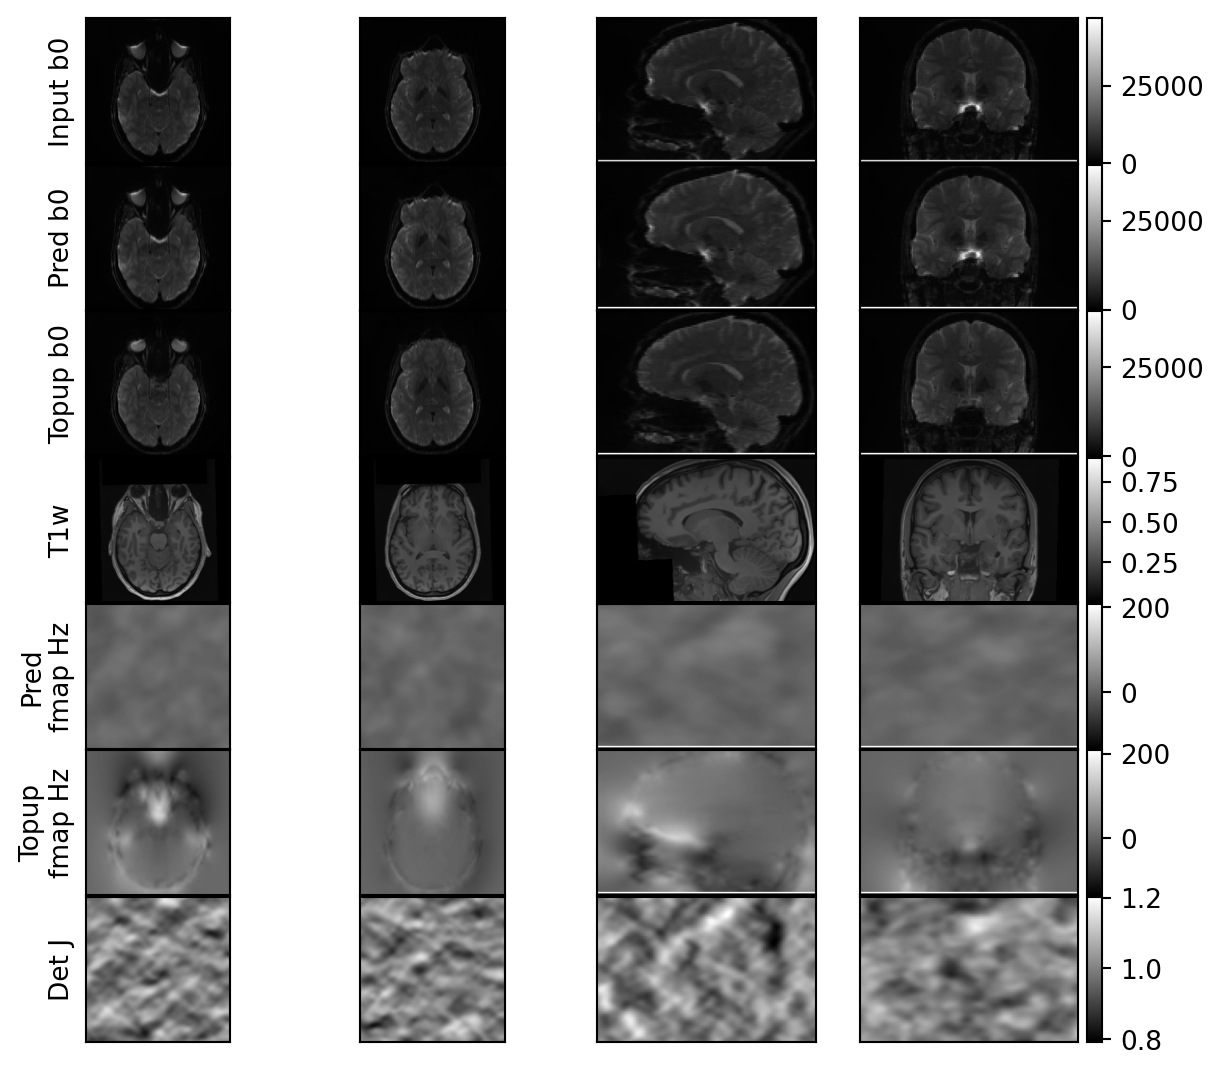



-0.469500706 | -0.413128421 | -0.490329355 | -0.437037170 | -0.457666904 | 
 Epoch 2 completed.
Learning rate(s):
[0.00018812499999999998]
Validation scores at epoch 2:
fixed_moving_mi: -0.368582845 | fixed_moving_ncc: -0.214893475 | det_J_def_neg_frac:  0.000000000 | topup_suscept_mse:  751.521545410 | masked_topup_suscept_mse:  751.521606445 | topup_corrected_b0_mse:  1125896.625000000 | masked_topup_corrected_b0_mse:  1125896.625000000 | 


<Figure size 640x480 with 0 Axes>

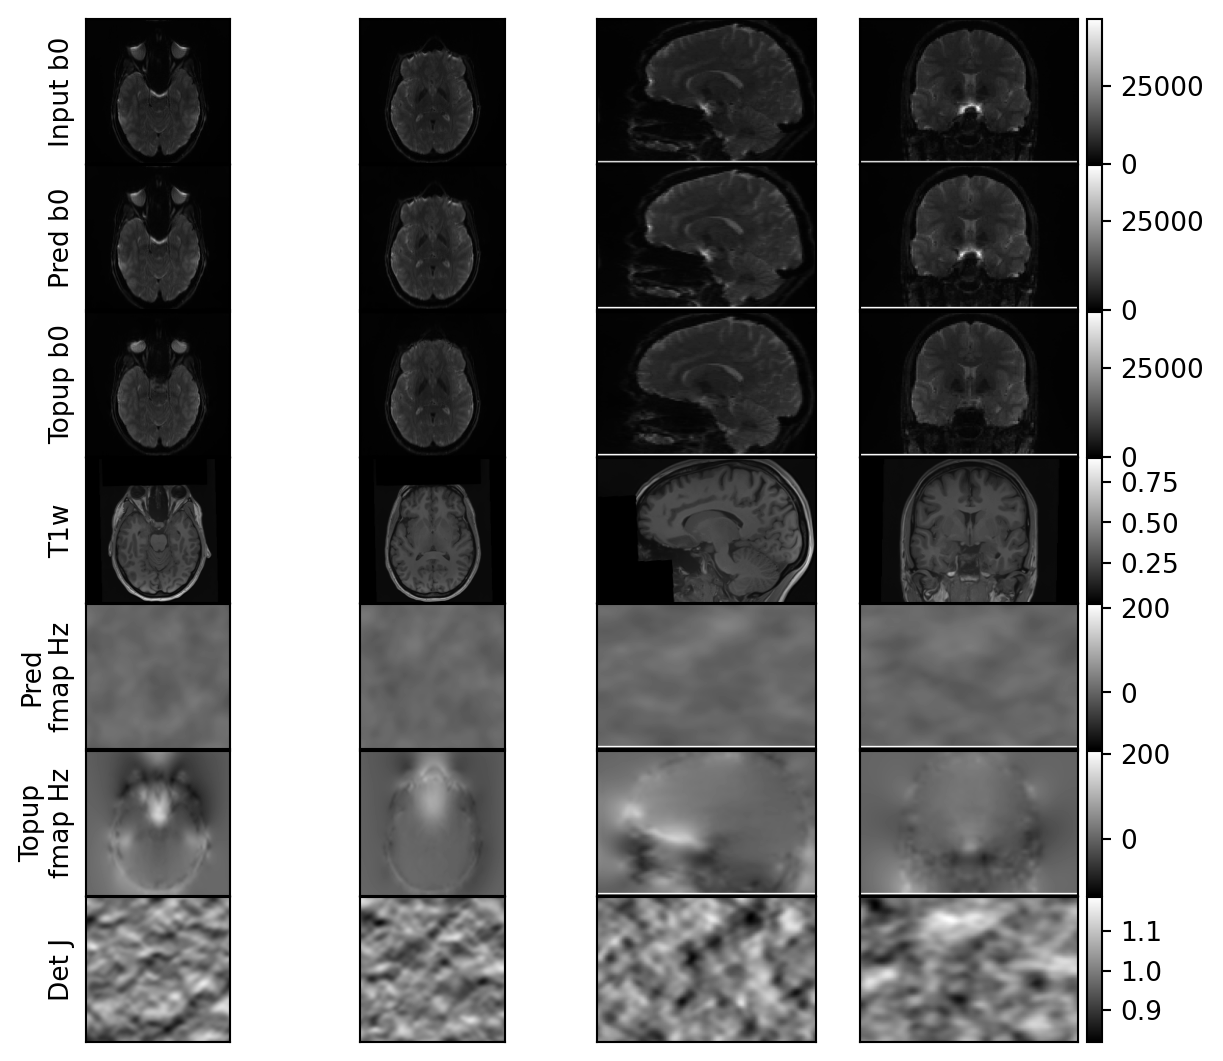



-0.448510975 | -0.439717084 | -0.457612395 | -0.469154090 | -0.450237572 | 
 Epoch 3 completed.
Learning rate(s):
[0.00012624999999999998]
Validation scores at epoch 3:
fixed_moving_mi: -0.368944168 | fixed_moving_ncc: -0.217221543 | det_J_def_neg_frac:  0.000000000 | topup_suscept_mse:  753.739807129 | masked_topup_suscept_mse:  753.739807129 | topup_corrected_b0_mse:  1091933.375000000 | masked_topup_corrected_b0_mse:  1091933.375000000 | 


<Figure size 640x480 with 0 Axes>

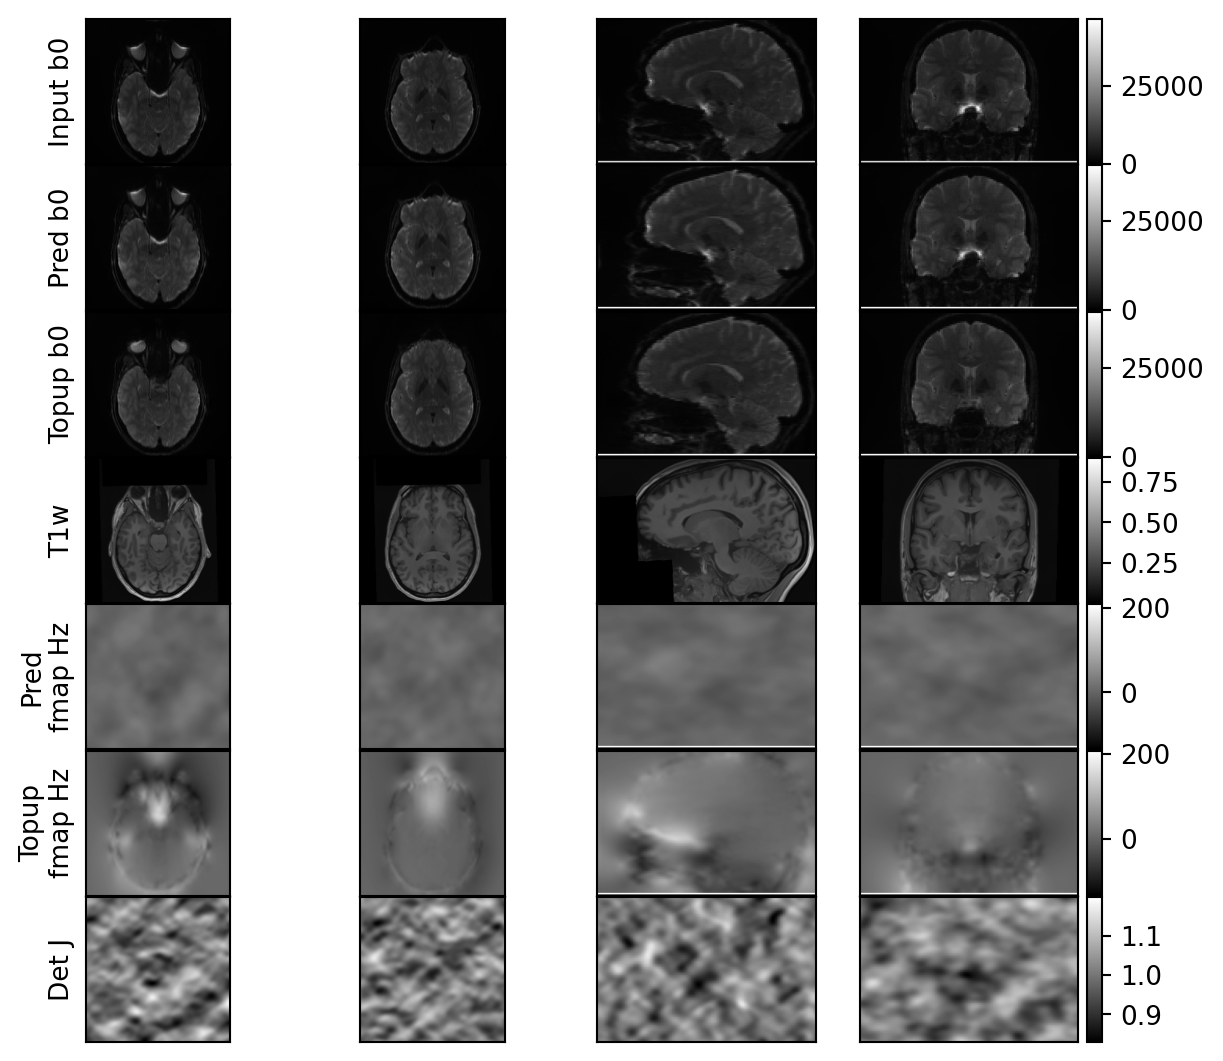



-0.523968413 | -0.357434228 | -0.424215972 | -0.468792066 | -0.514469936 | 
 Epoch 4 completed.
Learning rate(s):
[6.437499999999999e-05]
Validation scores at epoch 4:
fixed_moving_mi: -0.369172662 | fixed_moving_ncc: -0.218597069 | det_J_def_neg_frac:  0.000000000 | topup_suscept_mse:  736.663330078 | masked_topup_suscept_mse:  736.663330078 | topup_corrected_b0_mse:  1075366.250000000 | masked_topup_corrected_b0_mse:  1075366.250000000 | 


<Figure size 640x480 with 0 Axes>

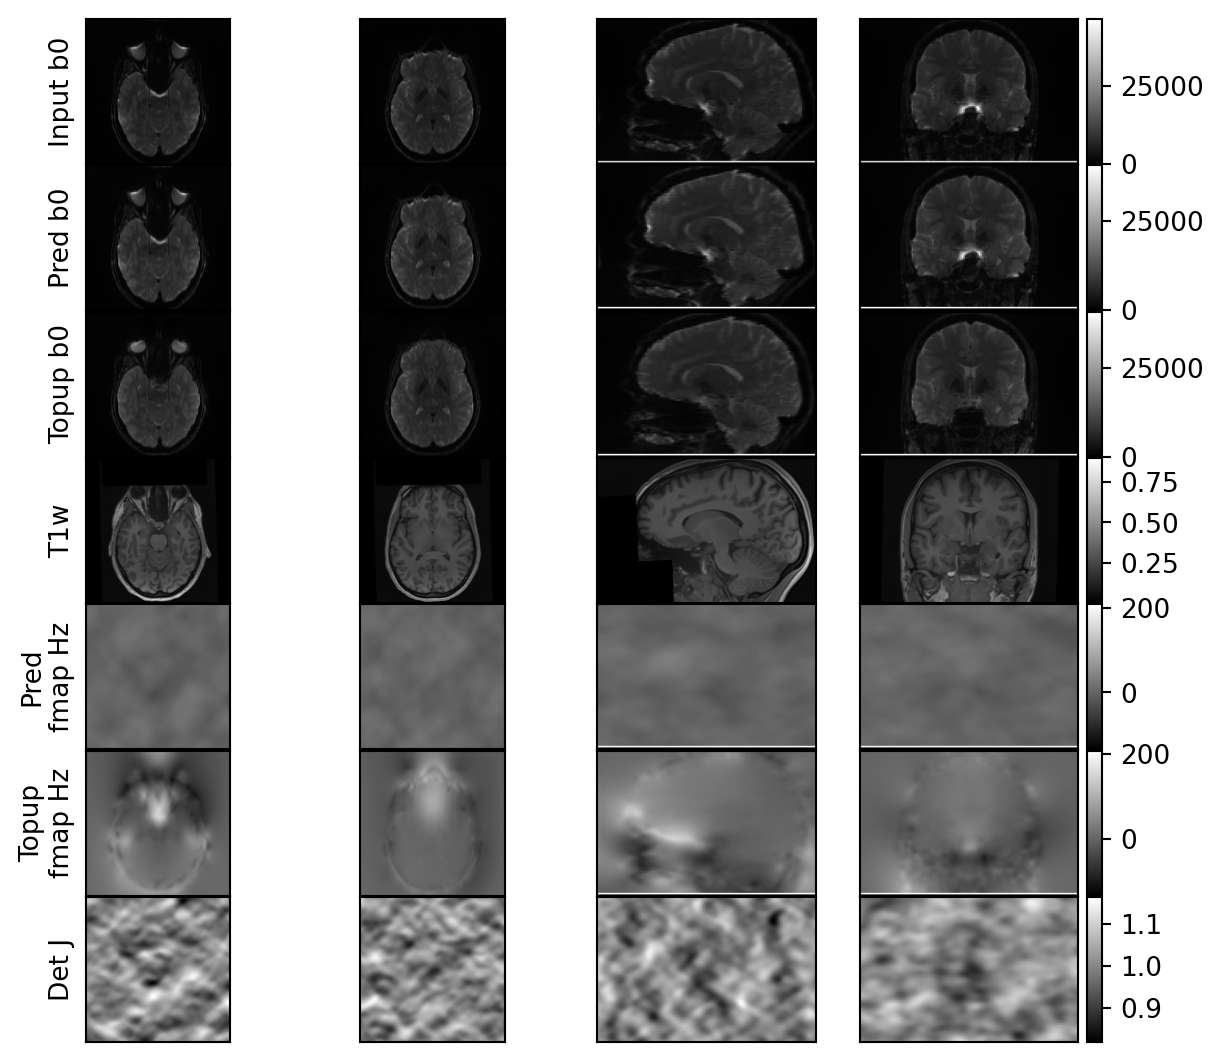



-0.375480279 | -0.439062774 | -0.459123418 | -0.504295230 | -0.470959619 | 
 Epoch 5 completed.
Learning rate(s):
[2.5e-06]


/opt/mambaforge/envs/mrinr2/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation scores at epoch 5:
fixed_moving_mi: -0.370560199 | fixed_moving_ncc: -0.220426127 | det_J_def_neg_frac:  0.000000000 | topup_suscept_mse:  706.582458496 | masked_topup_suscept_mse:  706.582458496 | topup_corrected_b0_mse:  1035835.187500000 | masked_topup_corrected_b0_mse:  1035835.187500000 | 


<Figure size 640x480 with 0 Axes>

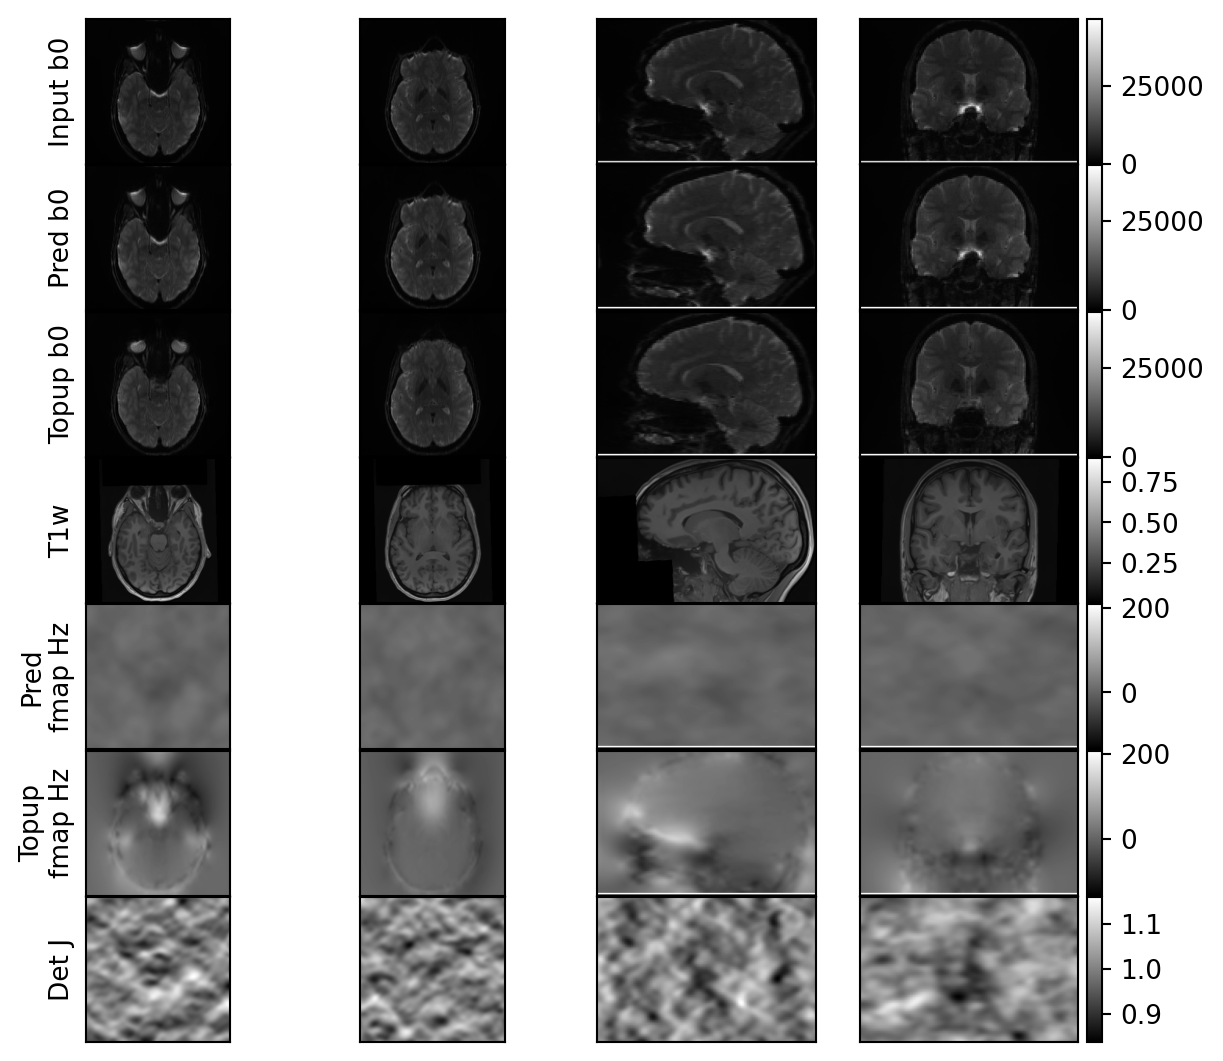



-0.525878191 | -0.458084494 | -0.420746982 | -0.554290026 | -0.473924592 | 
 Epoch 6 completed.
Learning rate(s):
[2.5e-06]
Validation scores at epoch 6:
fixed_moving_mi: -0.370624125 | fixed_moving_ncc: -0.220568076 | det_J_def_neg_frac:  0.000000000 | topup_suscept_mse:  706.030761719 | masked_topup_suscept_mse:  706.030761719 | topup_corrected_b0_mse:  1034450.437500000 | masked_topup_corrected_b0_mse:  1034450.437500000 | 


Saving training and validation scores...
Saving debug outputs...
Saving validation predicted displacement fields and undistorted b0s...


<Figure size 640x480 with 0 Axes>

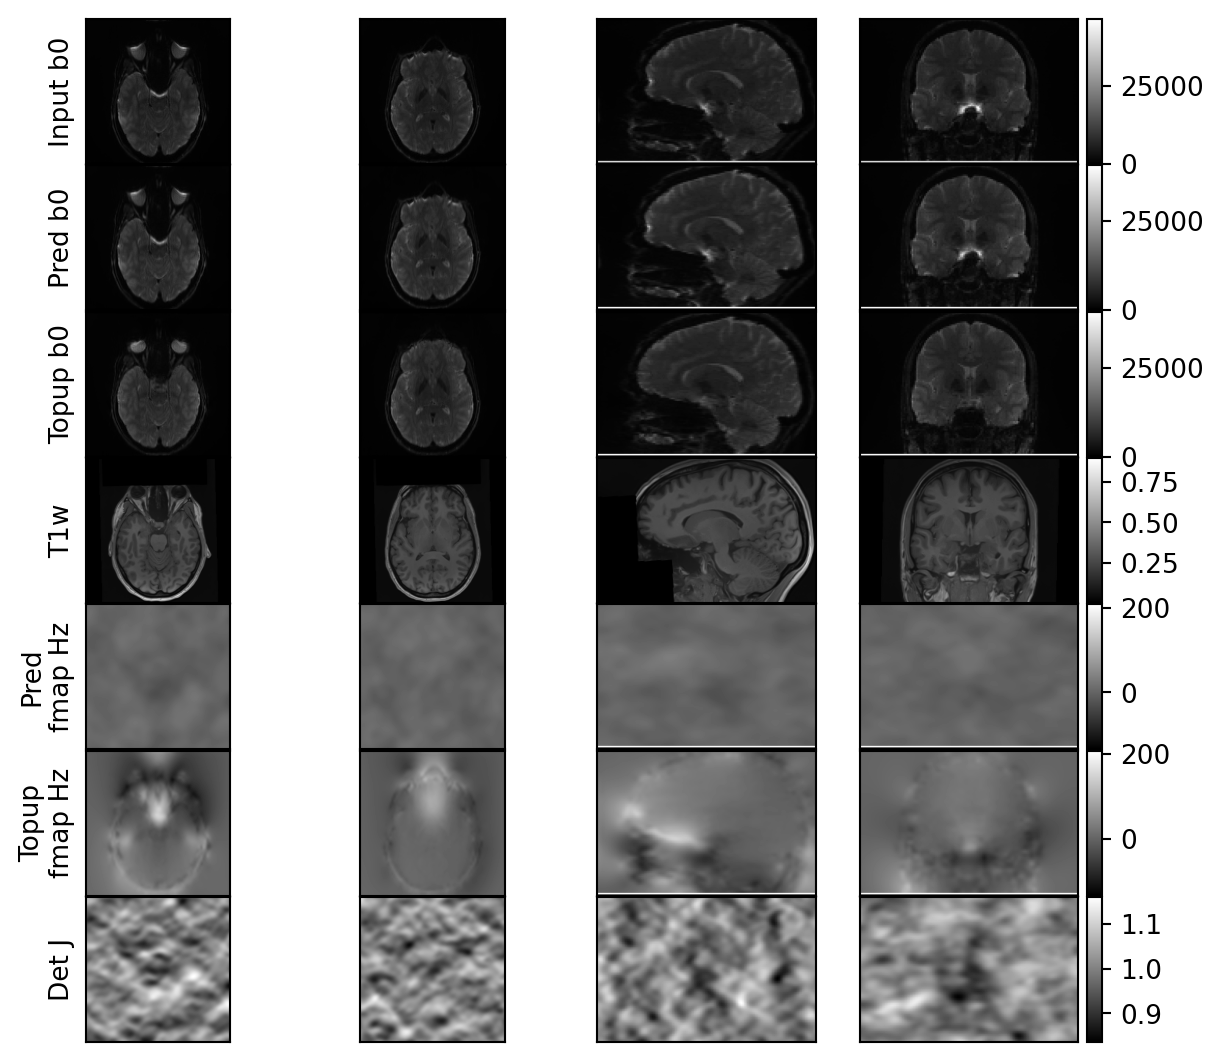

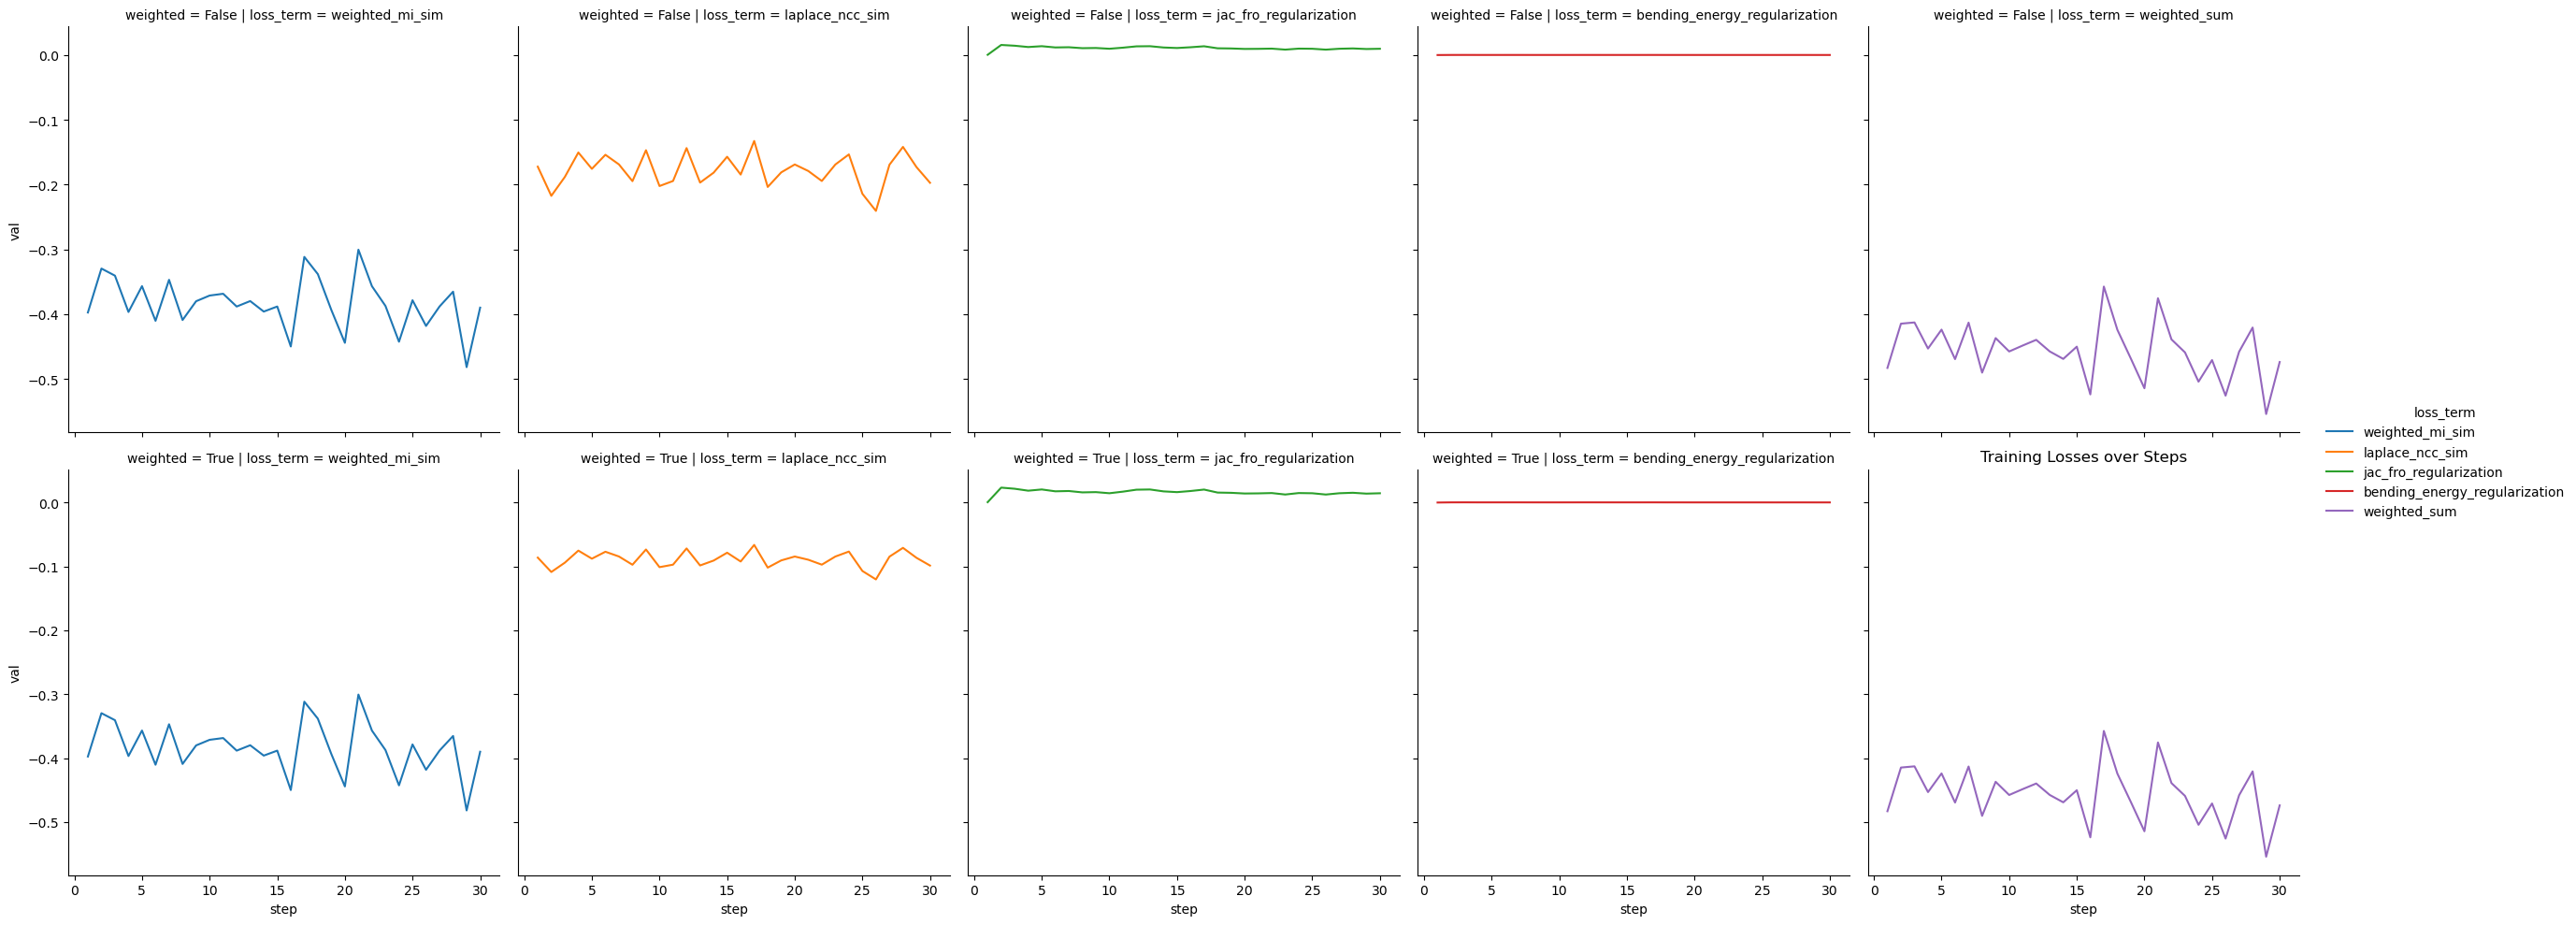

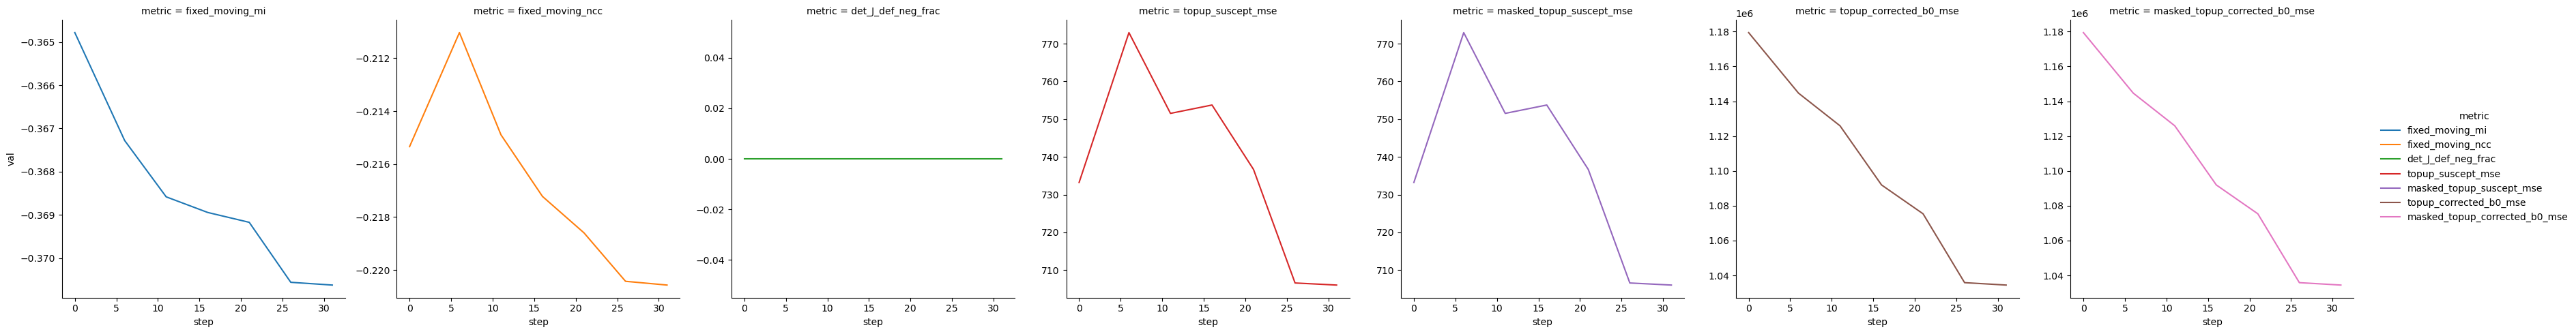

Finished subject mica_mics, sub-HC026.
Starting subject HC_09...
Resampling suscept_atlas_mm to b0 space...
Subject HC_09 already completed, skipping to next subject...
Moving temporary result dir
/home/tas6hh/mnt/magpie/outputs/results/epinr/dmri/epinr/tmp-2026-02-04T15_36_33-_yx5300t__2026-02-04T15_36_33_epinr_dmri_test
to final directory
/home/tas6hh/mnt/magpie/outputs/results/epinr/dmri/epinr/2026-02-04T15_36_33_epinr_dmri_test
Done


In [ ]:
# -------------------------------------------------------------------------
# Threshold in seconds that determines whether a log file is still being written to.
LOG_MTIME_RUNNING_THRESH_S = 30.0
#### Training loop.
dataset_table = pd.read_csv(params.dataset_table_f, index_col=None, comment="#")
dataset_table_rows = list(range(len(dataset_table)))
# Shuffle subject order to get better estimate of generalization performance, earlier,
# and to allow parallel runs with less risk of overlap in subjects being run.
np.random.shuffle(dataset_table_rows)

# Create experiment name.
timestamp_str = mrinr.utils.timestamp_now()
if not in_pml:
    if continue_previous_run:
        # Take from the experiment label.
        experiment_name = params.experiment_label
    else:
        # New experiment name.
        experiment_name = f"{timestamp_str}_{params.experiment_label}"
elif pml_config["subj_run_mode"] == "batch":
    # Already set in papermill config parsing.
    experiment_name = params.experiment_label
elif pml_config["subj_run_mode"] == "single":
    experiment_name = None
else:
    # Should not be reachable due to earlier validation.
    raise ValueError(f"Unsupported pml_subj_run_mode: {pml_config['subj_run_mode']}")

# Create or locate result directories.
if (not in_pml) or pml_config["subj_run_mode"] == "batch":
    final_result_dir = params.result_base_dir / experiment_name
    if continue_previous_run:
        # Look for existing result directory with the same experiment name.
        tmp_result_dir_matches = list(
            Path(params.result_base_dir).glob(f"tmp-*__{experiment_name}")
        )
        if len(tmp_result_dir_matches) == 1:
            tmp_result_dir = tmp_result_dir_matches[0].resolve()
            print(
                f"Found existing tmp result dir {tmp_result_dir} for experiment "
                f"{experiment_name}, continuing previous run."
            )
        elif len(tmp_result_dir_matches) > 1:
            raise ValueError(
                "Found multiple tmp result dirs matching experiment name "
                f"{experiment_name}: {tmp_result_dir_matches}.\n"
                "Cannot continue previous run."
            )
        else:
            continue_previous_run = False
            print(
                f"No existing tmp result dir found for experiment {experiment_name},"
                " starting new run.",
            )
    if not continue_previous_run:
        # Random tmp result dir.
        tmp_result_dir_name = tempfile.mkdtemp(
            dir=final_result_dir.parent,
            prefix=f"tmp-{timestamp_str}-",
            suffix=f"__{experiment_name}",
        )
        tmp_result_dir = Path(tmp_result_dir_name)
    result_dir = tmp_result_dir
    print(f"Experiment results will be saved to {result_dir}")
    # Save out parameters used for the experiment.
    p = copy.deepcopy(params.to_dict())
    with open(result_dir / "experiment_params.yaml", "w") as f:
        yaml.dump(params.to_dict(), f)
    del timestamp_str
elif pml_config["subj_run_mode"] == "single":
    final_result_dir = None
    # Use a random tmp result dir and copy move any desired output files from the
    # tmp dir at the end of the run.
    tmp_result_dir = params.result_base_dir
    result_dir = tmp_result_dir
else:
    # Should not be reachable due to earlier validation.
    raise ValueError(f"Unsupported pml_subj_run_mode: {pml_config['subj_run_mode']}")

# else:
#     dataset_table_rows = [45]
#     result_dir = Path("tmp").resolve()
#     final_result_dir = None


for dataset_table_row in dataset_table_rows:
    subj_table = dataset_table.iloc[dataset_table_row : (dataset_table_row + 1)]
    print(f"Starting subject {subj_table['subj_id'].values.item()}...")
    # Handle random seeding, created such that each subject has a unique and consistent
    # seed.
    random_seed = mrinr.utils.create_subj_rng_seed(
        base_rng_seed=1, subj_id=subj_table["subj_id"].values.item()
    ) % (2**32 - 1)
    torch.random.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
    patch_select_seed = np.random.randint(0, 2**32 - 1)

    # Load subject data.
    subj_data = load_dwi_subject_data(
        dataset_table=subj_table,
        dataset_dirs=params.dataset_dirs,
        device=device,
    )[0]
    print("Loaded subject data.")

    # Create a subject-specific output directory and filenames.
    subj_result_dir = (
        result_dir
        / f"{subj_data.dataset_name}_{subj_data.subj_id}_dir-{subj_data.pe_dir}"
    )
    subj_result_dir.mkdir(parents=True, exist_ok=True)

    # Standard output files.
    log_f = subj_result_dir / "log.txt"
    final_pred_displacement_hz_f = subj_result_dir / "epinr_suscept_field_hz.nii.gz"
    final_corrected_b0_f = subj_result_dir / "epinr_undistorted_b0.nii.gz"
    final_pred_displacement_mm_f = (
        subj_result_dir / f"epinr_displace_field_dir-{subj_data.pe_dir}_mm.nii.gz"
    )
    final_weights_f = subj_result_dir / "epinr_weights.pt"
    # Debug outputs, only saved if requested.
    debug_pred_displacement_fields_list = list()
    debug_pred_undistorted_b0s_list = list()
    debug_pred_displacement_fields_f = (
        subj_result_dir / "pred_displacement_fields_during_training.nii.gz"
    )
    debug_undistorted_b0s_f = subj_result_dir / "undistorted_b0s_during_training.nii.gz"
    final_debug_fig_f = subj_result_dir / "final_validation_viz.png"
    train_scores_f = subj_result_dir / "train_scores.csv"
    val_scores_f = subj_result_dir / "val_scores.csv"
    train_loss_plot_f = subj_result_dir / "train_loss_plot.png"
    val_scores_plot_f = subj_result_dir / "val_loss_plot.png"

    if final_pred_displacement_hz_f.exists():
        print(
            f"Subject {subj_data.subj_id} already completed,"
            " skipping to next subject..."
        )
        continue
    if log_f.exists():
        # Check if the log file has been modified in the last 30 seconds, to avoid
        # conflicts with other runs.
        log_mtime_delta = time.time() - os.path.getmtime(log_f)
        if log_mtime_delta < LOG_MTIME_RUNNING_THRESH_S:
            print(
                f"Subject {subj_data.subj_id} is currently running,"
                " skipping to next subject..."
            )
            continue
    # Remove any existing output files for this subject, if a previous run was stopped
    # before completion.
    for f in [
        log_f,
        final_pred_displacement_hz_f,
        final_corrected_b0_f,
        final_pred_displacement_mm_f,
        final_weights_f,
        debug_pred_displacement_fields_f,
        debug_undistorted_b0s_f,
        final_debug_fig_f,
        train_scores_f,
        val_scores_f,
        train_loss_plot_f,
        val_scores_plot_f,
    ]:
        if f is not None:
            f.unlink(missing_ok=True)
    # Set up logging for this subject.
    pr = partial(mrinr.utils.tee, file=log_f)
    pr(f"Subject row: {dataset_table_row}")
    pr(f"Random seed: {random_seed}")
    pr(f"Loaded subject {subj_data.dataset_name}, {subj_data.subj_id}.")

    # Prep volumes for training.
    train_vols = prep_vols(
        b0=subj_data.b0,
        b0_mask=subj_data.b0_mask,
        b0_affine=subj_data.b0_affine,
        t1w=subj_data.t1w,
        t1w_mask=subj_data.t1w_mask,
        t1w_affine=subj_data.t1w_affine,
        scale_kwargs=dict(
            winsorize_quantiles=params.winsorize_quantiles,
            feature_range=params.feature_range,
        ),
        blur_mask_kwargs=dict(
            sigma_mm=params.mask_blur_sigma_mm,
            truncate=params.mask_blur_truncate,
        ),
    )
    subj_data.scaled_b0 = train_vols["b0"]
    subj_data.scaled_t1w = train_vols["t1w"]
    b0_weight_mask = train_vols["b0_mask"]
    t1w_weight_mask = train_vols["t1w_mask"]

    # Append a batch dimension to all Tensors.
    data_d = dict()
    for k, v in dataclasses.asdict(subj_data).items():
        if isinstance(v, torch.Tensor):
            if "fov" in k:
                v = einops.rearrange(v, "ndim -> 1 1 1 ndim")
            elif "min_coord" in k:
                v = einops.rearrange(v, "ndim -> 1 1 1 ndim")
            data_d[k] = v.unsqueeze(0)
        else:
            data_d[k] = v
    subj_data = DWISubjectData(**data_d)
    b0_spacing = mrinr.coords.spacing(subj_data.b0_affine)
    b0_weight_mask.unsqueeze_(0)
    t1w_weight_mask.unsqueeze_(0)
    # 1 / 0

    # Convenience functions for resampling volumes.
    sample_t1w = lambda c: mrinr.grid_resample(
        subj_data.scaled_t1w.expand(c.shape[0], -1, -1, -1, -1),
        affine_x_el2coords=subj_data.t1w_affine,
        sample_coords=c,
        **params.resample_kwargs,
    )
    sample_b0 = lambda c: mrinr.grid_resample(
        subj_data.scaled_b0.expand(c.shape[0], -1, -1, -1, -1),
        affine_x_el2coords=subj_data.b0_affine,
        sample_coords=c,
        **params.resample_kwargs,
    )
    sample_t1w_weight_mask = lambda c: mrinr.grid_resample(
        t1w_weight_mask.expand(c.shape[0], -1, -1, -1, -1),
        affine_x_el2coords=subj_data.t1w_affine,
        sample_coords=c,
        **params.resample_kwargs,
    )
    sample_b0_weight_mask = lambda c: mrinr.grid_resample(
        b0_weight_mask.expand(c.shape[0], -1, -1, -1, -1),
        affine_x_el2coords=subj_data.b0_affine,
        sample_coords=c,
        **params.resample_kwargs,
    )

    # Construct a dataset and dataloader to split up the coordinate grids into patches, to
    # save memory during training.
    # The dataset needs a non-batched volume with channel dimensions (not coordinate
    # dimensions) on the cpu. So, move the coordinate grid to the cpu, remove the batch
    # dim, and convert the coord dim to a channel dim.
    to_be_patched_coord_grid = mrinr.nn.coords_as_channels(
        subj_data.b0_scanner_coord_grid.squeeze(0).cpu(), has_batch_dim=False
    )
    # Minibatch of smaller patches that are randomly drawn from the coordinate grid.
    # Combine the b0 and t1w weight masks for sampling.
    combined_b0_t1w_weight_mask = torch.maximum(
        sample_b0_weight_mask(subj_data.b0_scanner_coord_grid),
        sample_t1w_weight_mask(subj_data.b0_scanner_coord_grid),
    )
    coord_patch_dataset = monai.data.PatchDataset(
        # Data is a shallow copy of the same input coordinate grid, one copy for each batch
        # in the epoch.
        data=[
            {
                "coords": to_be_patched_coord_grid,
                "weight_mask": combined_b0_t1w_weight_mask.squeeze(0).cpu(),
            }
        ]
        * params.n_batches_per_epoch,
        patch_func=monai.transforms.RandWeightedCropDict(
            keys="coords",
            w_key="weight_mask",
            spatial_size=params.patch_size,
            num_samples=params.batch_size,
        ).set_random_state(seed=patch_select_seed),
        samples_per_image=params.batch_size,
    )
    ######
    coord_patch_dataloader = monai.data.DataLoader(
        coord_patch_dataset,
        batch_size=params.batch_size,
        num_workers=4,
        prefetch_factor=3,
        pin_memory=True,
        shuffle=False,
    )

    # Instantiate the EPINR model.
    epinr = EPINR(
        hidden_features=params.hidden_features,
        num_layers=params.num_layers,
        pe_dir=subj_data.pe_dir,
        non_rigid_affine=params.non_rigid_affine_layer,
        non_rigid_affine_nonzero_thresh=params.non_rigid_affine_nonzero_thresh,
        sigma=params.pos_enc_sigma,
        m_num_freqs=params.m_num_freqs,
        pos_enc=params.pos_enc_type,
        refine_fixed_rigid_affine=params.refine_fixed_rigid_affine,
        omega=params.omega,
        omega_0=params.omega_0,
        c=params.c,
    )
    epinr.to(device=device)
    epinr.train()
    pr("Model summary:")
    pr(epinr)
    # Instantiate the optimizer.
    optim = torch.optim.AdamW(
        [{"params": epinr.network_parameters()}]
        + (
            [{"params": epinr.fixed2moving_rigid_affine_parameters()}]
            if params.refine_fixed_rigid_affine
            else list()
        ),
        lr=params.optim_lr / params.grad_accumulate_steps,
        betas=params.optim_betas,
        weight_decay=params.optim_weight_decay,
        fused=True,
    )
    pr("Optimizer:")
    pr(optim)
    optim.zero_grad()
    warm_cooldown_epochs = math.ceil(
        params.epochs * params.lr_scheduler_warmup_cooldown_percent
    )
    lin_decay_lr_epochs = params.epochs - (2 * warm_cooldown_epochs)
    lr_scheduler = torch.optim.lr_scheduler.SequentialLR(
        optim,
        [
            torch.optim.lr_scheduler.ConstantLR(
                optim, factor=1.0, total_iters=warm_cooldown_epochs
            ),
            torch.optim.lr_scheduler.LinearLR(
                optim,
                start_factor=1.0,
                end_factor=params.lr_scheduler_end_factor,
                total_iters=lin_decay_lr_epochs,
            ),
            torch.optim.lr_scheduler.ConstantLR(
                optim,
                factor=params.lr_scheduler_end_factor,
                total_iters=warm_cooldown_epochs + 1,
            ),
        ],
        milestones=[warm_cooldown_epochs, lin_decay_lr_epochs + warm_cooldown_epochs],
    )
    pr("LR Scheduler milestones:")
    pr(lr_scheduler._milestones)
    if params.refine_fixed_rigid_affine:
        stop_rigid_aff_epoch = math.ceil(
            params.refine_fixed_rigid_affine_epoch_percent * params.epochs
        )
        pr(f"Will stop refining fixed rigid affine at epoch {stop_rigid_aff_epoch}.")
    else:
        stop_rigid_aff_epoch = math.inf

    # Loss functions.
    mse_loss = torch.nn.MSELoss(reduction="none").to(device)
    mi_loss = WeightedNMIParzenLoss(**params.mi_sim_kwargs, reduction="mean").to(device)
    ncc_loss = NCC(use_mask=False).to(device)
    lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
        spatial_dims=3, **params.lncc_sim_kwargs, reduction="mean"
    ).to(device)
    laplacian_fn = DoGLaplacian(
        sigma_low=params.laplacian_sigma_low, truncate=params.laplacian_truncate
    ).to(device)
    loss_fn = mrinr.nn.loss.WeightedSumLoss(
        loss_fns={
            "weighted_mse_sim": lambda pred, target, weight_mask: (
                mse_loss(pred, target) * weight_mask
            ).mean(),
            "weighted_mi_sim": mi_loss,
            "weighted_ncc_sim": ncc_loss,
            "weighted_lncc_sim": lncc_loss,
            "laplace_ncc_sim": lambda pred, target: lncc_loss(
                laplacian_fn(pred),
                laplacian_fn(1 - target),  # 1-T1w to invert contrast
                # laplacian_fn(target),  #! do not invert contrast
            ),
            "laplace_mse_sim": lambda pred, target, weight_mask: (
                mse_loss(
                    laplacian_fn(pred),
                    laplacian_fn(1 - target),  # 1-T1w to invert contrast
                    # laplacian_fn(target),  #! do not invert contrast
                )
                * weight_mask
            ).mean(),
            "jac_fro_regularization": jac_displace_fro_regularization,
            "bending_energy_regularization": lambda model,
            c: bending_energy_regularization(
                model,
                x_coords=c,
                grid_fov=subj_data.b0_fov,
                grid_min_coord=subj_data.b0_min_coord,
                pe_dir=subj_data.pe_dir,
                hessian_of_warp_type="deformation",
                compile_hessian=compile_hessian,
            ),
        },
        loss_weights=[
            params.mse_sim_weight,
            params.mi_sim_weight,
            params.ncc_sim_weight,
            params.lncc_sim_weight,
            params.laplacian_ncc_sim_weight,
            params.laplacian_mse_sim_weight,
            params.jac_fro_reg_weight,
            params.bending_energy_reg_weight,
        ],
    ).to(device)
    val_score_fns = {
        "fixed_moving_mi": monai.losses.GlobalMutualInformationLoss(
            **params.val_mi_sim_kwargs, reduction="mean"
        ).to(device),
        "fixed_moving_ncc": monai.losses.LocalNormalizedCrossCorrelationLoss(
            spatial_dims=3, **params.lncc_sim_kwargs, reduction="mean"
        ).to(device),
        "topup_suscept_mse": torch.nn.MSELoss(reduction="mean").to(device),
        "topup_corrected_b0_mse": torch.nn.MSELoss(reduction="mean").to(device),
        "masked_topup_suscept_mse": mrinr.nn.loss.WeightedMaskLoss(
            "mse", reduction="mean"
        ).to(device),
        "masked_topup_corrected_b0_mse": mrinr.nn.loss.WeightedMaskLoss(
            "mse", reduction="mean"
        ).to(device),
        "det_J_def_neg_frac": lambda J_deform: (
            (torch.linalg.det(J_deform) < 0.0).sum()
        )
        / J_deform[..., 0, 0].numel(),
    }

    ### Training loop
    train_loss = {
        "epoch": list(),
        "step": list(),
        "loss_term": list(),
        "val": list(),
        "weighted": list(),
    }
    accumulate_train_loss = collections.defaultdict(list)
    val_scores = {"epoch": list(), "step": list(), "metric": list(), "val": list()}
    step = 1
    batch_step = 1
    # Perform an initial validation step before any weight updating.
    epinr.eval()
    with torch.no_grad():
        val_results = validation_step(
            epinr=epinr,
            subj_data=subj_data,
            params=params,
            epoch=0,
            step=0,
            val_score_fns=val_score_fns,
            b0_spacing=b0_spacing,
            viz_validation_every=0,  # No visualization for this initial validation step.
            pr=pr,
        )
        debug_pred_displacement_fields_list.append(
            val_results["pred_displacement_field_mm"]
        )
        debug_pred_undistorted_b0s_list.append(val_results["pred_undistorted_b0"])
        for k, v in val_results["val_scores"].items():
            val_scores["epoch"].append(0)
            val_scores["step"].append(0)
            val_scores["metric"].append(k)
            val_scores["val"].append(v)
    pr("\n")

    ## Training loop.
    for epoch in range(1, params.epochs + 1):
        optim.zero_grad()
        epinr.train()
        # Iterate over batches of coordinate patches for this epoch.
        for i_epoch_batch, batch_dict in enumerate(coord_patch_dataloader):
            if ((i_epoch_batch + 1) % params.grad_accumulate_steps != 0) and (
                i_epoch_batch < (params.n_batches_per_epoch - 1)
            ):
                is_accumulating = True
            else:
                is_accumulating = False

            coords = mrinr.nn.channels_as_coords(
                batch_dict["coords"].to(device), has_batch_dim=True
            )

            # Forward pass
            pred_displacement_field_mm = epinr(
                x=coords,
                grid_fov=subj_data.b0_fov,
                grid_min_coord=subj_data.b0_min_coord,
            )
            pred_deformation_field_mm = coords + pred_displacement_field_mm

            # Sample the fixed t1w image.
            fixed_t1w_sample = sample_t1w(epinr.apply_fixed_rigid_affine(coords))

            # Sample moving image with Jacobian modulation at the predicted deformed
            # coordinates.
            J_pred = jacobian_matrix_batched(
                pred_displacement_net=epinr,
                x_coords=coords,
                grid_fov=subj_data.b0_fov,
                grid_min_coord=subj_data.b0_min_coord,
                jac_of_warp_type="displacement",
                compile_jacobian=True,
            )
            if params.enable_jac_mod_in_training:
                if params.use_analytic_jac_mod:
                    det_j_continuous_displace = 1 + J_pred[:, None, ..., 1, 1]
                    moving_b0_sample = det_j_continuous_displace * sample_b0(
                        pred_deformation_field_mm
                    )
                else:
                    det_J_discrete_displace = central_diff_det_j(
                        pred_displacement_field_mm,
                        spacing=b0_spacing,
                        pe_dir=subj_data.pe_dir,
                    )
                    moving_b0_sample = det_J_discrete_displace * sample_b0(
                        pred_deformation_field_mm
                    )
            else:
                moving_b0_sample = sample_b0(pred_deformation_field_mm)
            b0_scanner_space_weight_mask = torch.maximum(
                sample_b0_weight_mask(coords),
                sample_t1w_weight_mask(epinr.apply_fixed_rigid_affine(coords)),
            )
            # Compute loss.
            loss, loss_term_vals = loss_fn(
                weighted_mse_sim=(
                    moving_b0_sample,
                    fixed_t1w_sample,
                    b0_scanner_space_weight_mask,
                ),
                weighted_mi_sim=(
                    moving_b0_sample,
                    fixed_t1w_sample,
                    b0_scanner_space_weight_mask,
                ),
                weighted_ncc_sim=(moving_b0_sample, fixed_t1w_sample),
                weighted_lncc_sim=(moving_b0_sample, fixed_t1w_sample),
                laplace_ncc_sim=(moving_b0_sample, fixed_t1w_sample),
                laplace_mse_sim=(
                    moving_b0_sample,
                    fixed_t1w_sample,
                    b0_scanner_space_weight_mask,
                ),
                jac_fro_regularization=J_pred,
                bending_energy_regularization=(epinr, coords),
                return_loss_terms=True,
            )

            loss.backward()

            # Record unweighted loss values, along with weighted sum.
            for loss_term, loss_val in (
                loss_term_vals
                | {"weighted_sum": {"value": loss.detach().cpu().item(), "weight": 1.0}}
            ).items():
                accumulate_train_loss[loss_term].append(loss_val)

            if not is_accumulating:
                optim.step()
                optim.zero_grad()
                # Store averages of each loss term for this step.
                for loss_term, acc_loss_vals_weights in accumulate_train_loss.items():
                    l_vals = [l["value"] for l in acc_loss_vals_weights]
                    l_weight = [l["weight"] for l in acc_loss_vals_weights]
                    loss_value = np.mean(l_vals)
                    loss_weight = np.median(l_weight)
                    for l_val, is_weighted in zip(
                        (loss_value, loss_value * loss_weight), (False, True)
                    ):
                        train_loss["epoch"].append(epoch)
                        train_loss["step"].append(step)
                        train_loss["loss_term"].append(loss_term)
                        train_loss["val"].append(l_val)
                        train_loss["weighted"].append(is_weighted)
                        if loss_term == "weighted_sum" and not is_weighted:
                            loss_str = f"{loss_value: 10.9f}"
                            pr(f"{loss_str} | ", end="")
                accumulate_train_loss.clear()
                # Only update step after the model was updated.
                step += 1
            # Always update batch_step, even if accumulating.
            batch_step += 1
        pr("\n")
        pr(f" Epoch {epoch} completed.")
        # Epoch completed, update LR scheduler.
        lr_scheduler.step()
        if epoch == stop_rigid_aff_epoch:
            pr("Stopping fixed rigid affine refinement.")
        if epoch >= stop_rigid_aff_epoch:
            optim.param_groups[1]["lr"] = 0.0
        pr("Learning rate(s):")
        pr([pg["lr"] for pg in optim.param_groups])

        # Validation step
        epinr.eval()
        with torch.no_grad():
            val_results = validation_step(
                epinr=epinr,
                subj_data=subj_data,
                params=params,
                epoch=epoch,
                step=step,
                val_score_fns=val_score_fns,
                b0_spacing=b0_spacing,
                viz_validation_every=params.viz_validation_every_n_epochs,
                pr=pr,
            )
            debug_pred_displacement_fields_list.append(
                val_results["pred_displacement_field_mm"]
            )
            debug_pred_undistorted_b0s_list.append(val_results["pred_undistorted_b0"])
            for k, v in val_results["val_scores"].items():
                val_scores["epoch"].append(epoch)
                val_scores["step"].append(step)
                val_scores["metric"].append(k)
                val_scores["val"].append(v)
        pr("-" * 55 + "\n")

    # Training is completed, save out results.
    final_pred_displacement_field_mm = debug_pred_displacement_fields_list[-1]
    final_corrected_b0 = debug_pred_undistorted_b0s_list[-1]
    if final_pred_displacement_mm_f is not None:
        nib.save(
            nib.Nifti1Image(
                final_pred_displacement_field_mm,
                affine=subj_data.b0_affine.cpu().numpy().squeeze(0),
            ),
            final_pred_displacement_mm_f,
        )
    if final_pred_displacement_hz_f is not None:
        final_pred_suscept_field_hz = (
            (final_pred_displacement_field_mm * (-1 if subj_data.pe_dir == "ap" else 1))
            / b0_spacing[0, 1].cpu().numpy()
        ) / subj_data.total_readout_time_s
        nib.save(
            nib.Nifti1Image(
                final_pred_suscept_field_hz,
                affine=subj_data.b0_affine.cpu().numpy().squeeze(0),
            ),
            final_pred_displacement_hz_f,
        )
    if final_corrected_b0_f is not None:
        nib.save(
            nib.Nifti1Image(
                final_corrected_b0,
                affine=subj_data.b0_affine.cpu().numpy().squeeze(0),
            ),
            final_corrected_b0_f,
        )
    if final_weights_f is not None:
        torch.save(epinr.state_dict(), final_weights_f)
    train_loss = pd.DataFrame.from_dict(train_loss)
    val_scores = pd.DataFrame.from_dict(val_scores)
    pr("Saving training and validation scores...")
    train_loss.to_csv(train_scores_f, index=False)
    val_scores.to_csv(val_scores_f, index=False)
    if save_debug_outputs:
        pr("Saving debug outputs...")
        # Save validation predicted displacement fields and undistorted b0s.
        debug_pred_displacement_fields_arr = np.stack(
            debug_pred_displacement_fields_list, axis=-1
        )
        debug_pred_undistorted_b0s_arr = np.stack(
            debug_pred_undistorted_b0s_list, axis=-1
        )
        pr("Saving validation predicted displacement fields and undistorted b0s...")
        nib.save(
            nib.Nifti1Image(
                debug_pred_displacement_fields_arr,
                affine=subj_data.b0_affine.cpu().numpy().squeeze(0),
            ),
            debug_pred_displacement_fields_f,
        )
        nib.save(
            nib.Nifti1Image(
                debug_pred_undistorted_b0s_arr,
                affine=subj_data.b0_affine.cpu().numpy().squeeze(0),
            ),
            debug_undistorted_b0s_f,
        )
        plt.savefig(final_debug_fig_f)
        plt.show()

        # Plot training and validation scores.
        sns.relplot(
            train_loss,
            x="step",
            y="val",
            row="weighted",
            col="loss_term",
            hue="loss_term",
            kind="line",
            facet_kws={"sharey": "row", "sharex": True},
        )
        plt.title("Training Losses over Steps")
        plt.savefig(train_loss_plot_f)
        if not in_pml:
            plt.show()
        else:
            plt.clf()
        sns.relplot(
            val_scores,
            x="step",
            y="val",
            col="metric",
            hue="metric",
            kind="line",
            facet_kws={"sharey": False, "sharex": True},
        )
        plt.savefig(val_scores_plot_f)
        if not in_pml:
            plt.show()
        else:
            plt.clf()

    pr(f"Finished subject {subj_data.dataset_name}, {subj_data.subj_id}.")

if (not in_pml) or pml_config["subj_run_mode"] == "batch":
    # Determine if we should move the tmp result dir to the final result dir.
    # Allow the current worker's subject log file to have an mtime greater than the
    # given threshold.
    time.sleep(LOG_MTIME_RUNNING_THRESH_S + 1)
    log_files = list(tmp_result_dir.glob("**/log.txt"))
    t = time.time()
    still_running = any(
        [(t - os.path.getmtime(f)) < LOG_MTIME_RUNNING_THRESH_S for f in log_files]
    )
    final_pred_hz_f_list = [
        d / final_pred_displacement_hz_f.name for d in tmp_result_dir.glob("**")
    ]
    still_running = still_running and all([f.exists() for f in final_pred_hz_f_list])

    if still_running:
        print(
            f"At least one subject has not been completed for experiment {params.experiment_label}. "
            "If any dangling subjects are present, they can be removed and rerunning "
            "will finalize the experiment.\n"
            "Not moving tmp result dir to final result dir to avoid conflicts."
        )
    else:
        print(
            f"Moving temporary result dir\n{tmp_result_dir}\nto final directory\n{final_result_dir}"
        )
        tmp_result_dir.rename(final_result_dir)
elif pml_config["subj_run_mode"] == "single":
    # Copy/move files to desired output location(s).
    if pml_config["out_fmap"] is not None:
        if pml_config["out_fmap"].exists():
            print(
                f"Output fmap file {pml_config['out_fmap']} already exists, deleting..."
            )
            pml_config["out_fmap"].unlink()
        shutil.copyfile(final_pred_displacement_hz_f, pml_config["out_fmap"])
    if pml_config["out_corrected_b0"] is not None:
        if pml_config["out_corrected_b0"].exists():
            print(
                f"Output corrected b0 file {pml_config['out_corrected_b0']} already exists, deleting..."
            )
            pml_config["out_corrected_b0"].unlink()
        shutil.copyfile(final_corrected_b0_f, pml_config["out_corrected_b0"])
    if pml_config["out_weights"] is not None:
        if pml_config["out_weights"].exists():
            print(
                f"Output weights file {pml_config['out_weights']} already exists, deleting..."
            )
            pml_config["out_weights"].unlink()
        shutil.copyfile(final_weights_f, pml_config["out_weights"])
    if pml_config["out_debug_dir"] is not None:
        if pml_config["out_debug_dir"].exists():
            print(
                f"Output debug dir {pml_config['out_debug_dir']} already exists, deleting..."
            )
            shutil.rmtree(pml_config["out_debug_dir"])
        subj_result_dir.rename(pml_config["out_debug_dir"])
    else:
        print("No output paths specified in papermill config, deleting debug files.")
        shutil.rmtree(tmp_result_dir)
print("Done")
# -------------------------------------------------------------------------

---

In [ ]:
# raise RuntimeError("Stop here, sandbox only beyond this point.")